<h1>Metadata</h1>
<table>
  <thead>
    <tr>
      <th>Column</th>
      <th>Description</th>
      <th>Type</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>
        <code>person_age</code>
      </td>
      <td>Age of the person</td>
      <td>Float</td>
    </tr>
    <tr>
      <td>
        <code>person_gender</code>
      </td>
      <td>Gender of the person</td>
      <td>Categorical</td>
    </tr>
    <tr>
      <td>
        <code>person_education</code>
      </td>
      <td>Highest education level</td>
      <td>Categorical</td>
    </tr>
    <tr>
      <td>
        <code>person_income</code>
      </td>
      <td>Annual income</td>
      <td>Float</td>
    </tr>
    <tr>
      <td>
        <code>person_emp_exp</code>
      </td>
      <td>Years of employment experience</td>
      <td>Integer</td>
    </tr>
    <tr>
      <td>
        <code>person_home_ownership</code>
      </td>
      <td>Home ownership status (e.g., rent, own, mortgage)</td>
      <td>Categorical</td>
    </tr>
    <tr>
      <td>
        <code>loan_amnt</code>
      </td>
      <td>Loan amount requested</td>
      <td>Float</td>
    </tr>
    <tr>
      <td>
        <code>loan_intent</code>
      </td>
      <td>Purpose of the loan</td>
      <td>Categorical</td>
    </tr>
    <tr>
      <td>
        <code>loan_int_rate</code>
      </td>
      <td>Loan interest rate</td>
      <td>Float</td>
    </tr>
    <tr>
      <td>
        <code>loan_percent_income</code>
      </td>
      <td>Loan amount as a percentage of annual income</td>
      <td>Float</td>
    </tr>
    <tr>
      <td>
        <code>cb_person_cred_hist_length</code>
      </td>
      <td>Length of credit history in years</td>
      <td>Float</td>
    </tr>
    <tr>
      <td>
        <code>credit_score</code>
      </td>
      <td>Credit score of the person</td>
      <td>Integer</td>
    </tr>
    <tr>
      <td>
        <code>previous_loan_defaults_on_file</code>
      </td>
      <td>Indicator of previous loan defaults</td>
      <td>Categorical</td>
    </tr>
    <tr>
      <td>
        <code>loan_status(target variable)</code> 
      </td>
      <td>Loan approval status: 1 = approved; 0 = rejected</td>
      <td>Integer</td>
    </tr>
  </tbody>
</table>




source: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
store = pd.HDFStore(os.getenv("store_data"))

In [276]:
data = store["loan_data"];data.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0          22        female           Master        71948.0               0   
1          21        female      High School        12282.0               0   
2          25        female      High School        12438.0               3   
3          23        female         Bachelor        79753.0               0   
4          24          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    Personal          16.02   
1                   OWN     1000.0   Education          11.14   
2              MORTGAGE     5500.0     Medical          12.87   
3                  RENT    35000.0     Medical          15.23   
4                  RENT    35000.0     Medical          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                           3           561   
1                 0.08                           2           504   
2                 0.44                           3           635   
3                 0.44                           2           675   
4                 0.53                           4           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

<h1>Data Cleaning and Preparations</h1>

In [278]:
def strip_cols_and_cat_values(df: "DataFrame") -> "DataFrame":
    """ Returns a new dataframe by removing spaces from the data in variable names and categorical variables"""
    
    df.columns = df.columns.str.strip()
    
    cat_cols = df.select_dtypes(include = "object").columns
    
    df[cat_cols] = df[cat_cols].apply(lambda x: x.str.strip())
    
    return df

data = strip_cols_and_cat_values(data)

data = data.astype({
    "person_age": "int",
    "cb_person_cred_hist_length": "int"
})


data = data.drop(index = data[data["person_age"] > 100].index)

def trans_text(x):
    
    if x.startswith("HOME"):
        return "Home Improvement"
    elif x.startswith("DEBT"):
        return "Debt Consolidation"
    else:
        return x.capitalize()
    

data["loan_intent"] = list(map(trans_text, data.loan_intent))

data = data.drop("loan_percent_income", axis = 1)

In [218]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [280]:
from sklearn.model_selection import train_test_split

x = data.drop("loan_status", axis = 1)
y = data["loan_status"]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=365, stratify=y)


In [284]:
education_order = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]

label_encoder = Pipeline([
    ("label encoder", OrdinalEncoder())
])

ohe_encoder = Pipeline([
    ("one-hot encoder", OneHotEncoder(drop = "first", sparse_output=False, handle_unknown="ignore"))
])

ord_encoder = Pipeline([
    ("ordinal encoder", OrdinalEncoder(categories=education_order))
])

scaler = Pipeline([
    ("scaler", StandardScaler())
])

label_cols = ["person_gender", "previous_loan_defaults_on_file"]
ohe_cols = ["person_home_ownership", "loan_intent"]
ord_cols = ["person_education"]
std_cols = x_train.select_dtypes(include="number").columns.to_list()

cols_transformed = ColumnTransformer([
    ("encoder_label", label_encoder, label_cols),
    ("encoder_ohe", ohe_encoder, ohe_cols),
    ("encoder_ord", ord_encoder, ord_cols),
    ("scaler_std", scaler, std_cols)

])

cols_transformed.fit(x_train)

ColumnTransformer(transformers=[('encoder_label',
                                 Pipeline(steps=[('label encoder',
                                                  OrdinalEncoder())]),
                                 ['person_gender',
                                  'previous_loan_defaults_on_file']),
                                ('encoder_ohe',
                                 Pipeline(steps=[('one-hot encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['person_home_ownership', 'loan_intent']),
                                ('encoder_ord',
                                 Pipeline(steps=[('ordinal encoder',
                                                  OrdinalEncoder(categories=[['High '
                                                                              'School',
                                                                              'Associate',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctorate']]))]),
                                 ['person_education']),
                                ('scaler_std',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_exp', 'loan_amnt',
                                  'loan_int_rate', 'cb_person_cred_hist_length',
                                  'credit_score'])])

In [286]:
x_train_final = pd.DataFrame(data = cols_transformed.transform(x_train), columns = cols_transformed.get_feature_names_out())
x_test_final = pd.DataFrame(data = cols_transformed.transform(x_test), columns = cols_transformed.get_feature_names_out())


<h1>EDA-Exploratory Data Analysis</h1>

### Continuous Variables Summary Table

In [228]:
table_cont = data.drop("loan_status", axis = 1).select_dtypes(include="number").describe()
table_cont.style.format(precision = 2, thousands = ".", decimal = ",")

### Distribution of Continuous Features

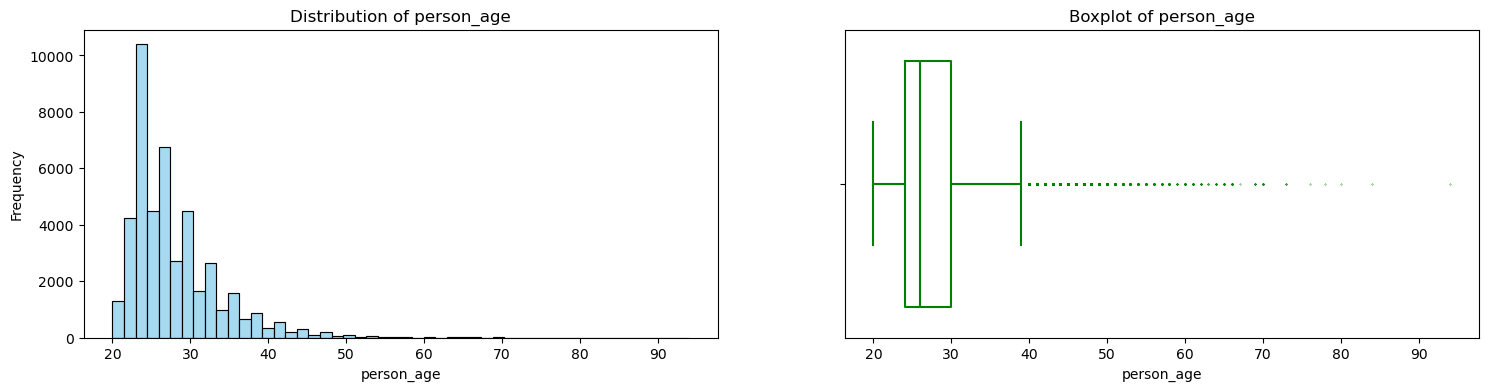

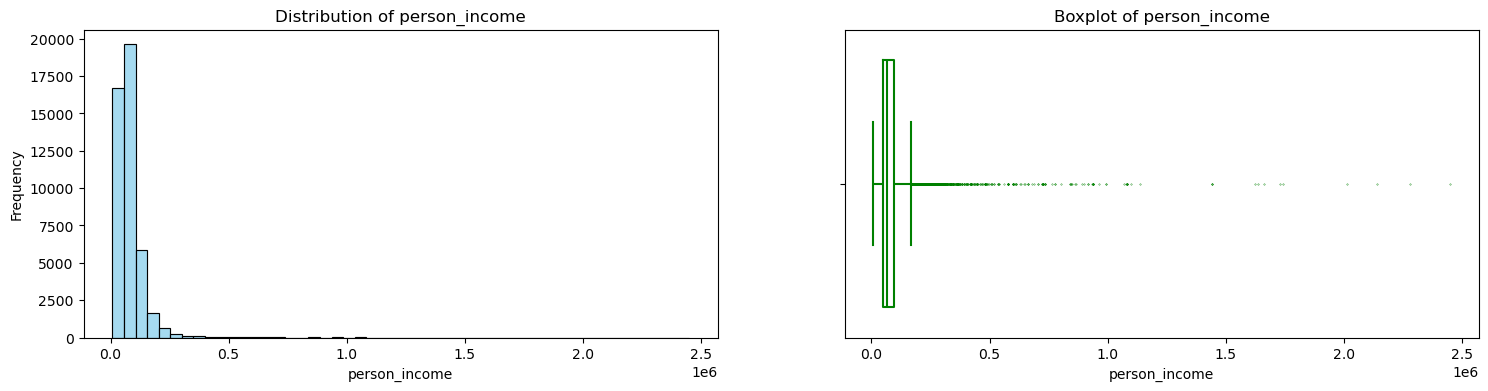

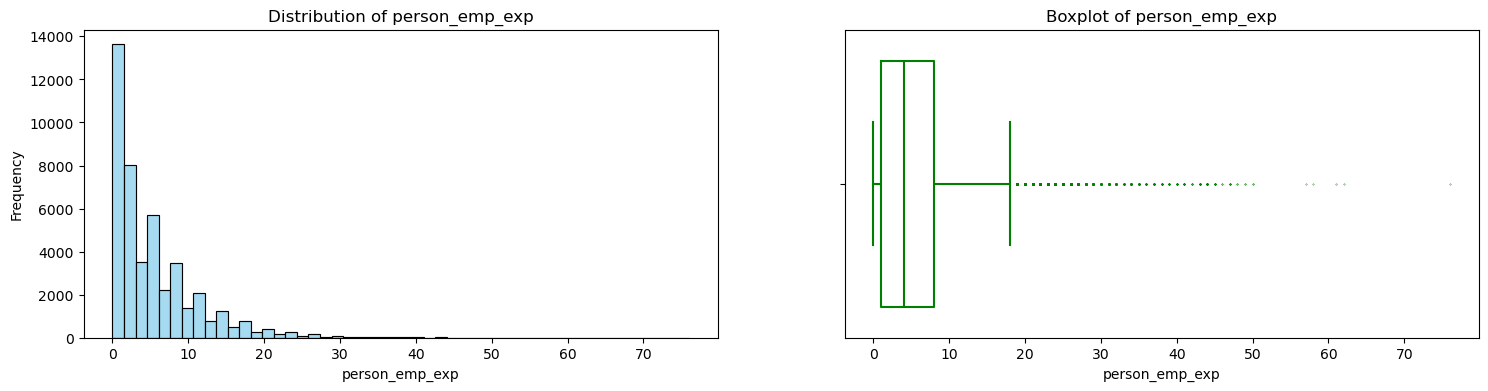

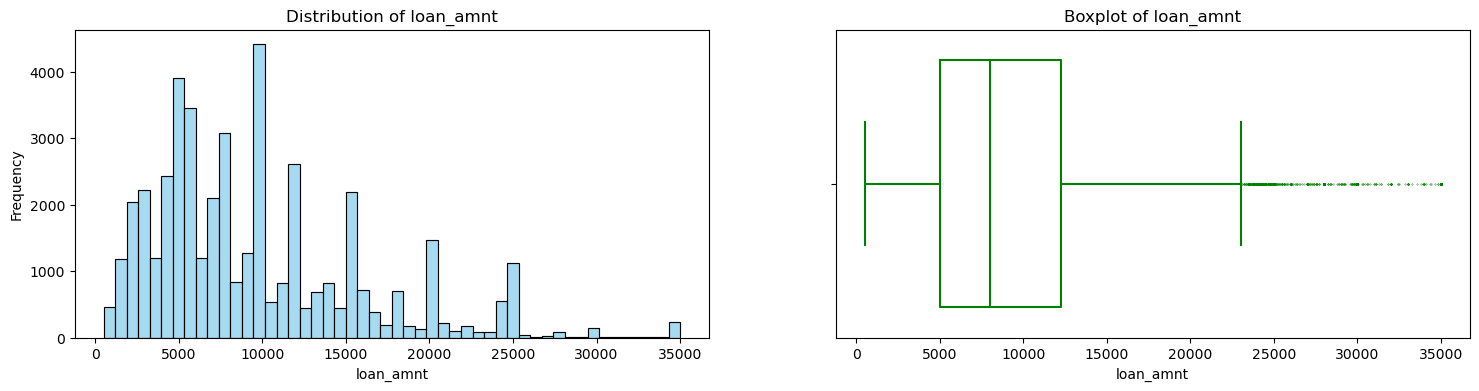

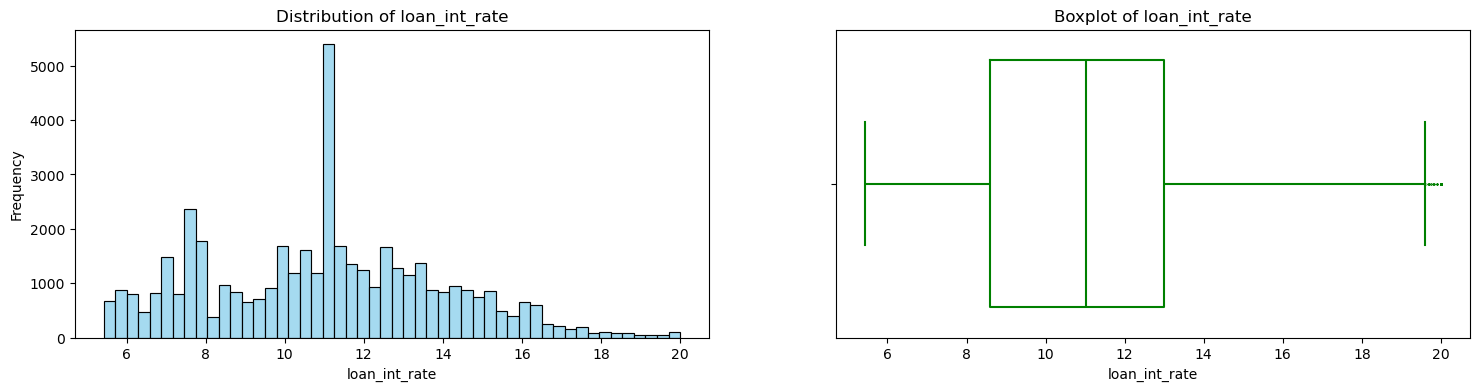

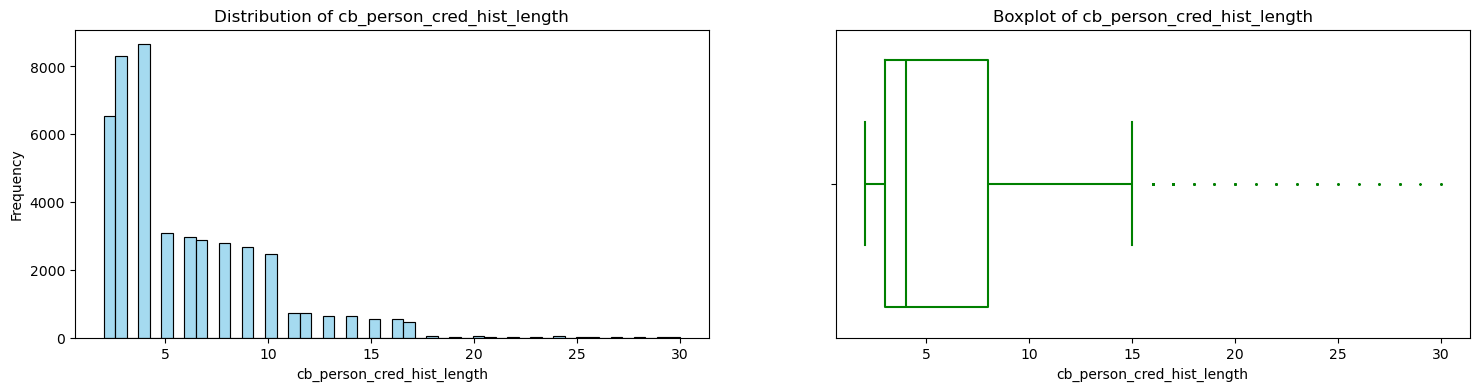

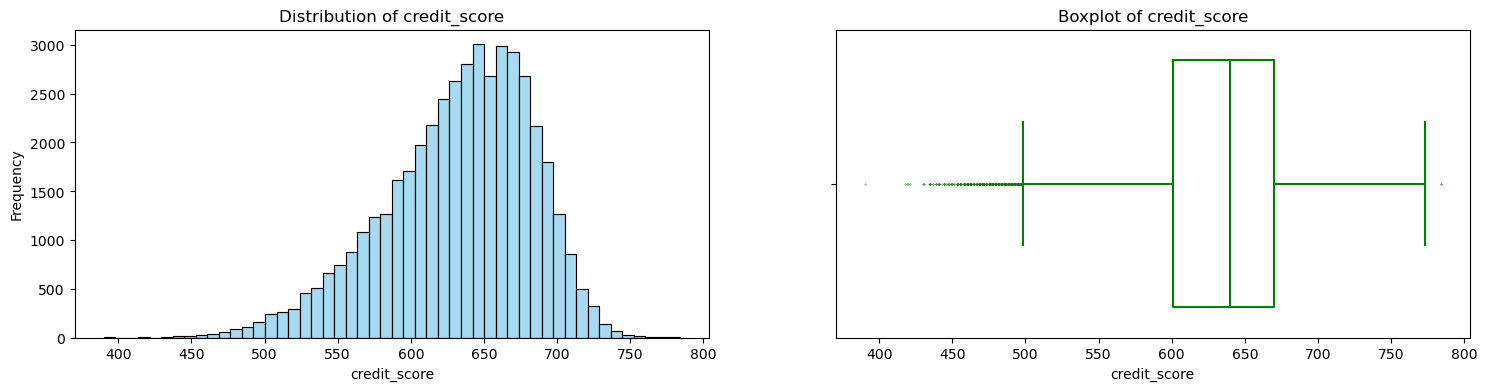

In [231]:
for column in table_cont.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

    sns.histplot(data[column], kde=False, color='skyblue', ax=ax1, bins=50)
    ax1.set_title(f'Distribution of {column}')
    ax1.set_ylabel('Frequency')

    sns.boxplot(x=data[column], color='green', ax=ax2, fill=False, fliersize=0.3)
    ax2.set_title(f'Boxplot of {column}')

### Categorical Variables Summary Table

In [234]:
table_cat = data.select_dtypes(include="object").assign(loan_status = data["loan_status"].astype("str")).describe()
table_cat.style.format(precision = 2, thousands = ".", decimal = ",")

### Distribution of Categorical Features

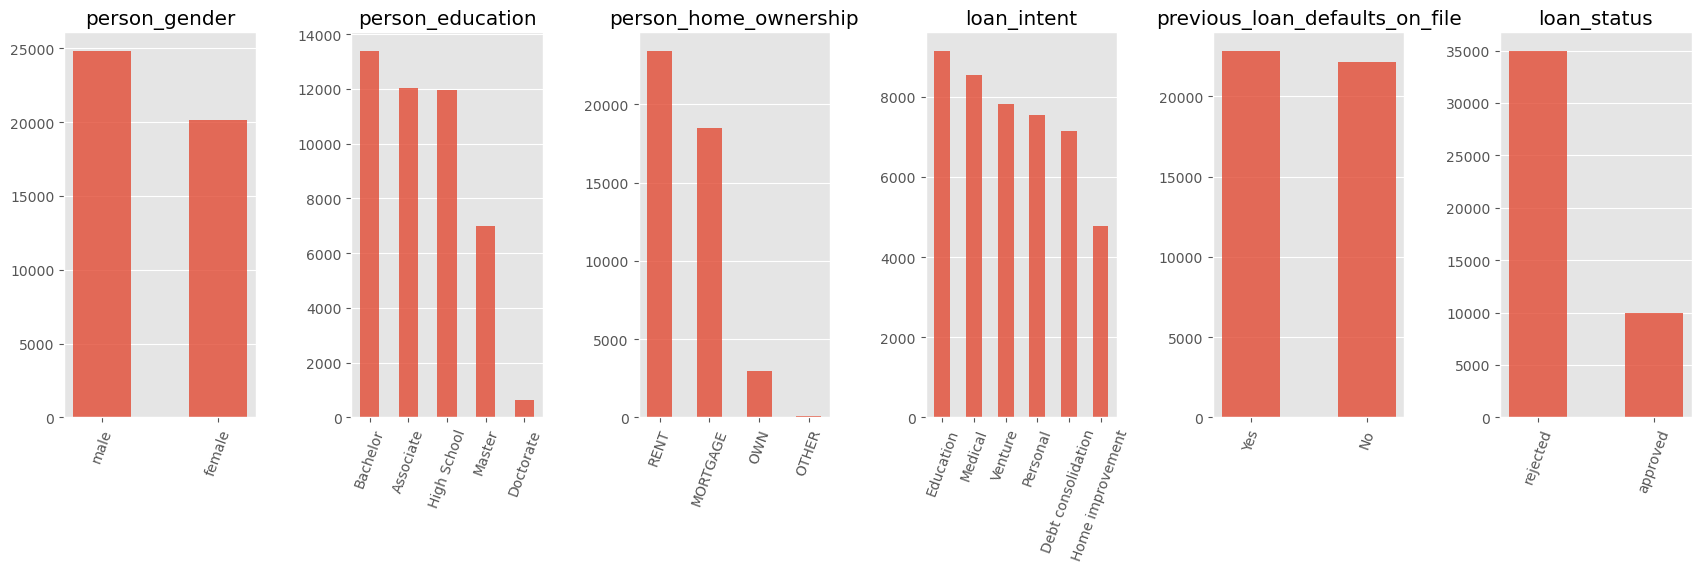

In [237]:
plt.style.use("ggplot")
cat_data = data.select_dtypes(include = "object").assign(loan_status = data["loan_status"].map({0:"rejected", 1:"approved"}))
cols = cat_data.columns.to_list()

plt.figure(figsize = (21, 5), dpi = 100)
for item in enumerate(cols):
    plt.subplot(1, 6, (item[0] + 1))
    counts = cat_data[item[1]].value_counts()
    plt.bar(x = counts.index, height=counts.values, width=0.5, alpha = 0.8)
    plt.xticks(rotation = 70)
    plt.title(f"{item[1]}")
    plt.grid(visible=False, axis = "x")

plt.subplots_adjust(hspace = 0.8, wspace= 0.5)
plt.show()

### Correlation Heatmap

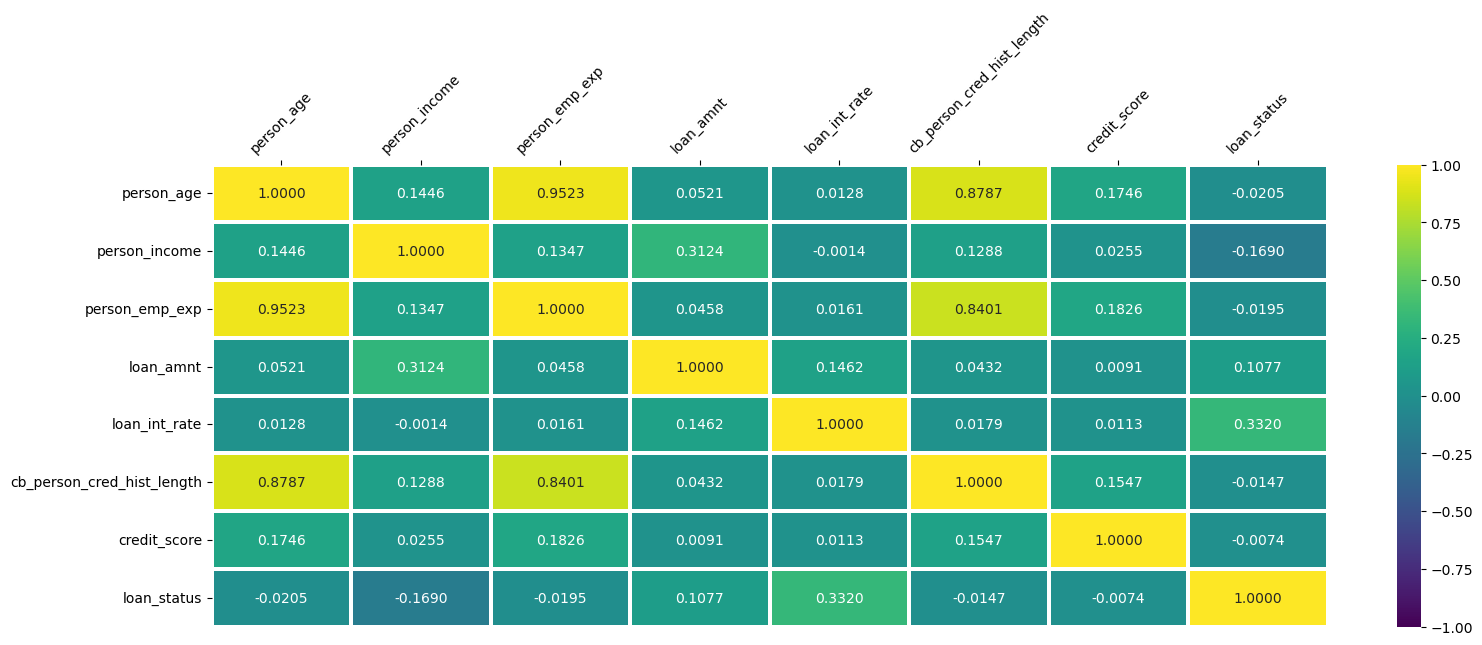

In [248]:
plt.style.use("default")
corr_matris = data.select_dtypes(include="number").corr()
ax = sns.heatmap(corr_matris, 
            vmax= 1,
            vmin= -1,
            annot= True, 
            linewidths = 1.5, 
            robust= True, 
            center = 0, 
            fmt = ".4f", 
            cmap = "viridis"
            )
plt.gcf().set_size_inches(18, 6)
ax.set(xlabel = "", ylabel = "")
ax.xaxis.tick_top()
plt.xticks(rotation = 45);

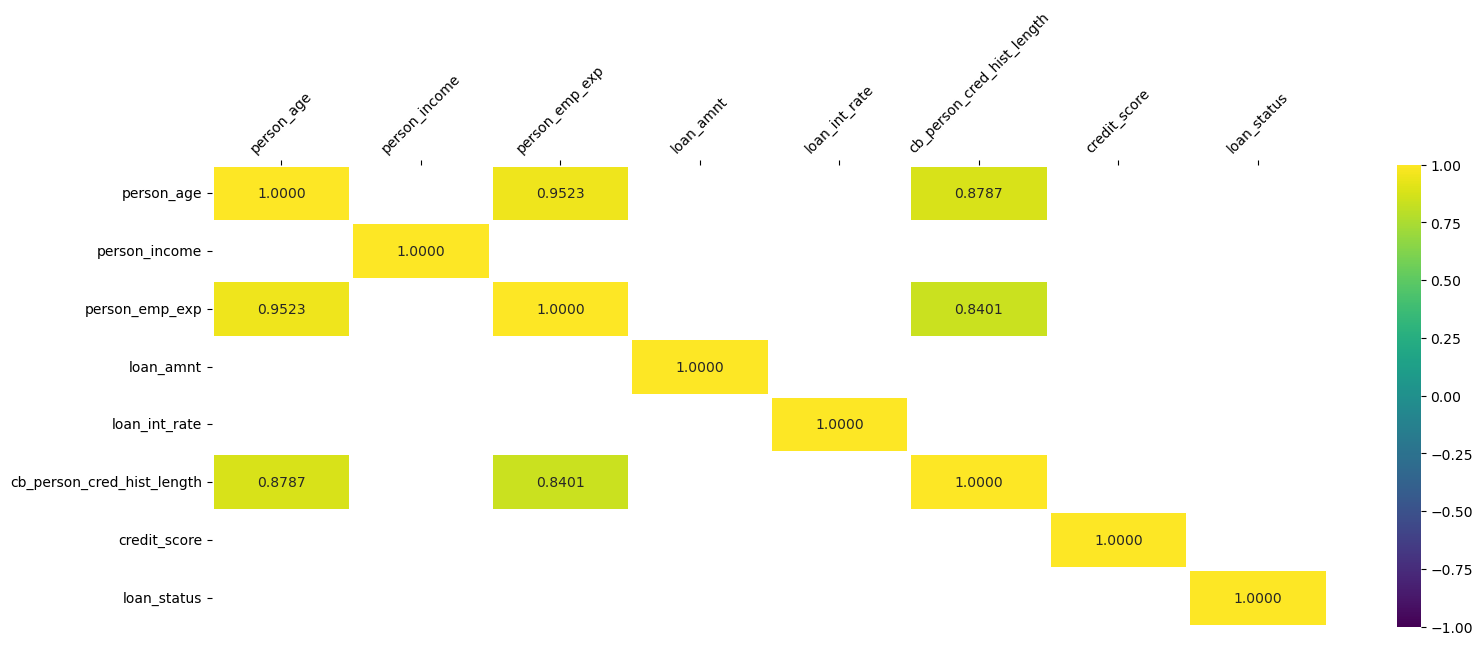

In [246]:
plt.style.use("default")
corr_matris = data.select_dtypes(include="number").corr()
ax = sns.heatmap(corr_matris, 
            vmax= 1,
            vmin= -1,
            annot= True, 
            linewidths = 1.5, 
            robust= True, 
            center = 0, 
            fmt = ".4f", 
            cmap = "viridis",
            mask=((corr_matris < 0.50) & (corr_matris > -0.50)).values
            )
plt.gcf().set_size_inches(18, 6)
ax.set(xlabel = "", ylabel = "")
ax.xaxis.tick_top()
plt.xticks(rotation = 45);

### Person Income vs Key Factors by Loan Status

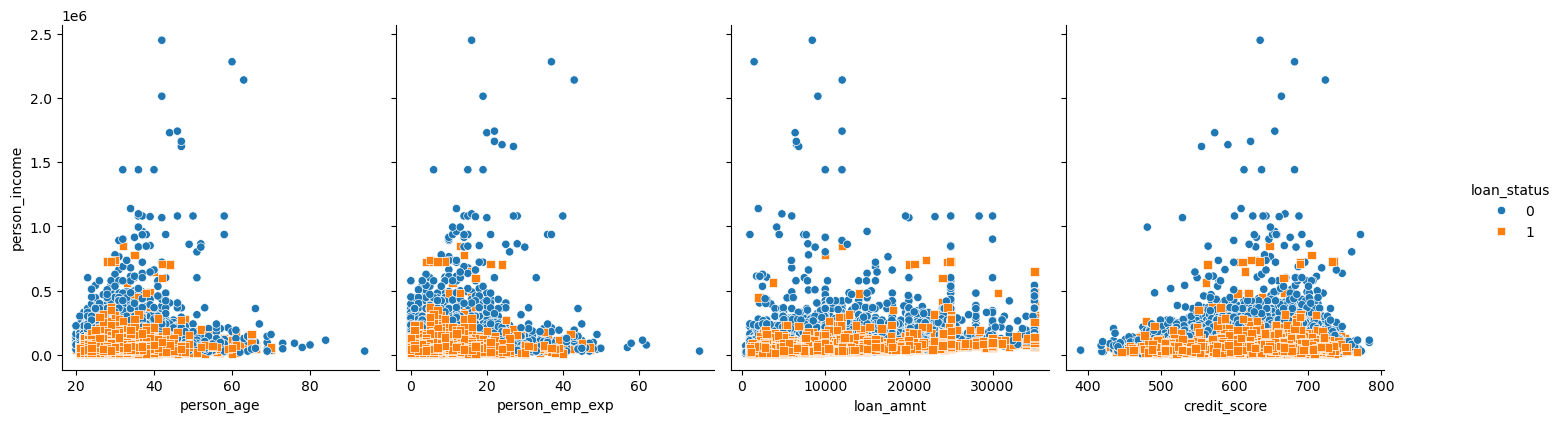

In [250]:
g = sns.pairplot(data = data, 
             x_vars=["person_age", "person_emp_exp", "loan_amnt", "credit_score"],
             y_vars=["person_income"],
             hue="loan_status",
             markers=["o", "s"],
             
             )

plt.gcf().set_size_inches(16, 5)

### ViolinPlots

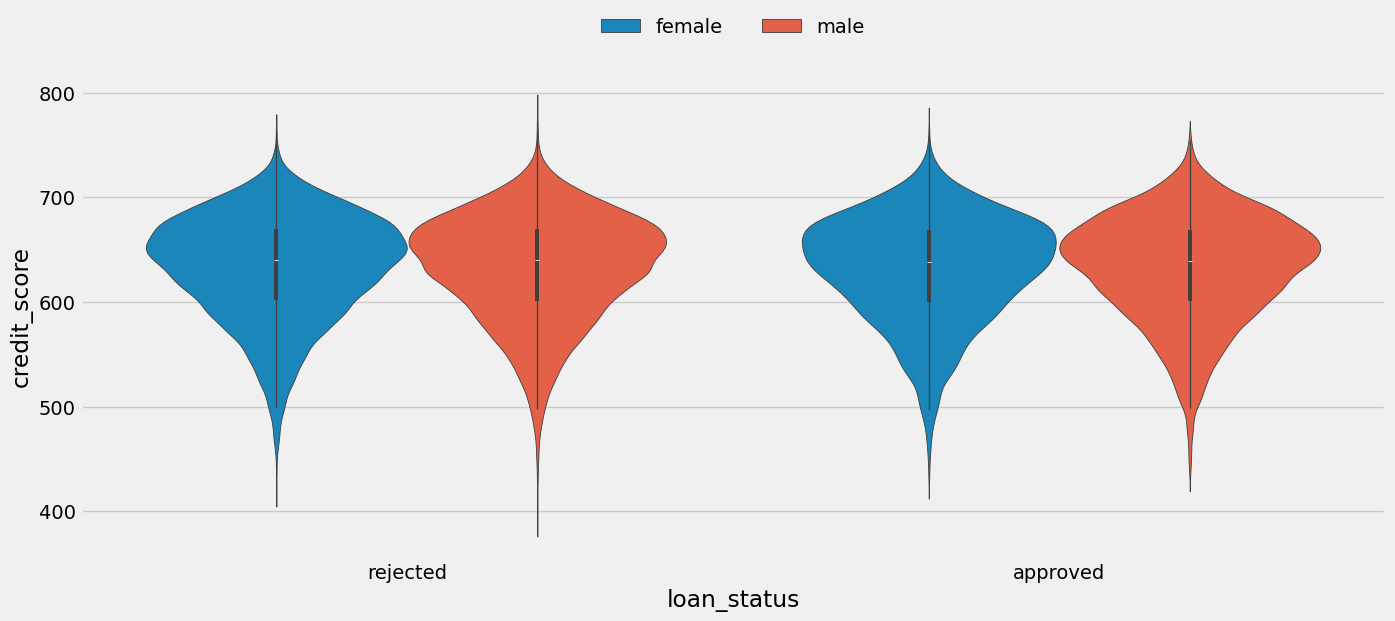

In [251]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 6), dpi = 100)
sns.violinplot(data = data, y = "credit_score", x = "loan_status", hue = "person_gender")
plt.legend(loc = "upper center", bbox_to_anchor = (0.50 , 1.15), ncols = 2, framealpha = 0.01)
plt.xticks([0, 1], labels=["rejected", "approved"]);

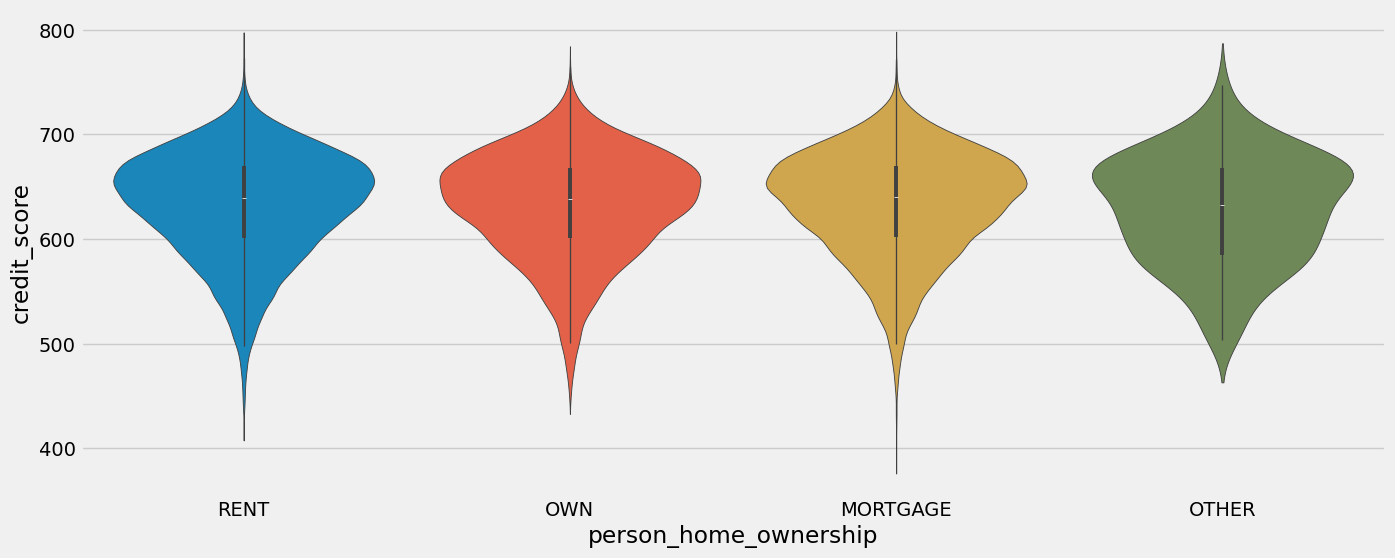

In [252]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 6), dpi = 100)
sns.violinplot(data = data, y = "credit_score", x = "person_home_ownership", hue = "person_home_ownership");

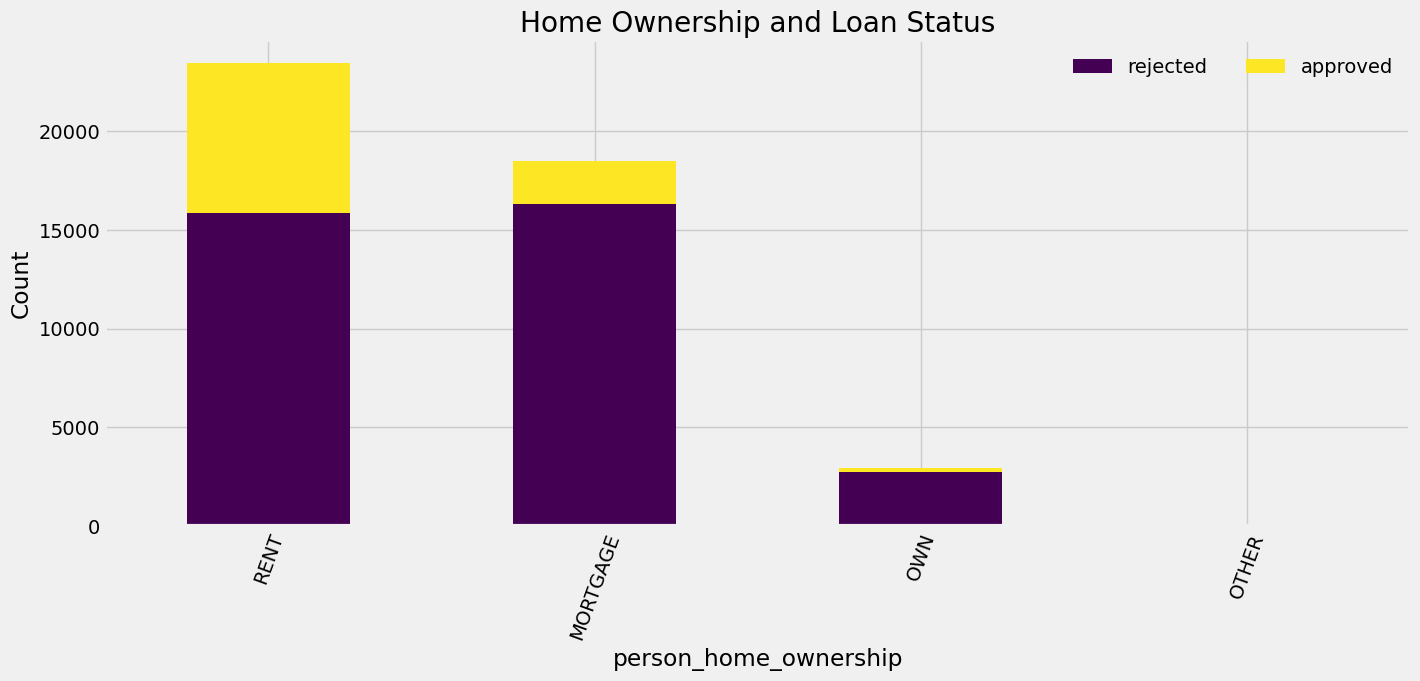

In [254]:
plt.style.use("fivethirtyeight")
cross_tab = pd.crosstab(data["person_home_ownership"], data["loan_status"]).sort_values(by = 1, ascending = False)
cross_tab.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='viridis')
plt.xticks(rotation = 70)
plt.legend(loc = "upper right", ncols = 2, framealpha = 0.01, labels = ["rejected", "approved"])
plt.ylabel("Count")
plt.title("Home Ownership and Loan Status");

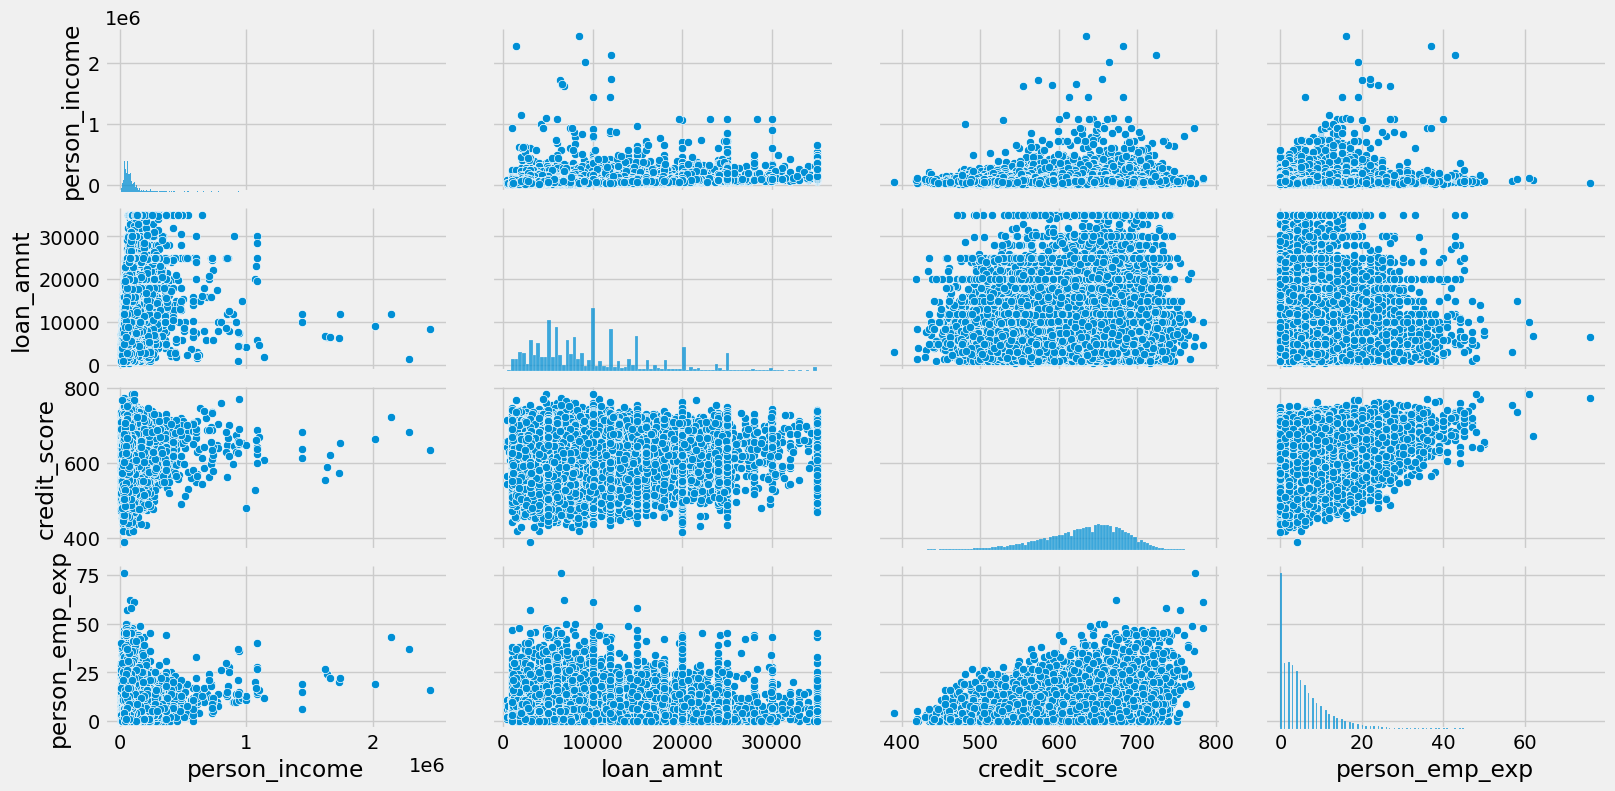

In [258]:
sns.pairplot(data[["person_income", "loan_amnt", "credit_score", "person_emp_exp"]], diag_kind="hist", diag_kws=dict(fill=True))
plt.gcf().set_size_inches(15, 7)
plt.gcf().subplots_adjust(5, 12, 6, 13)

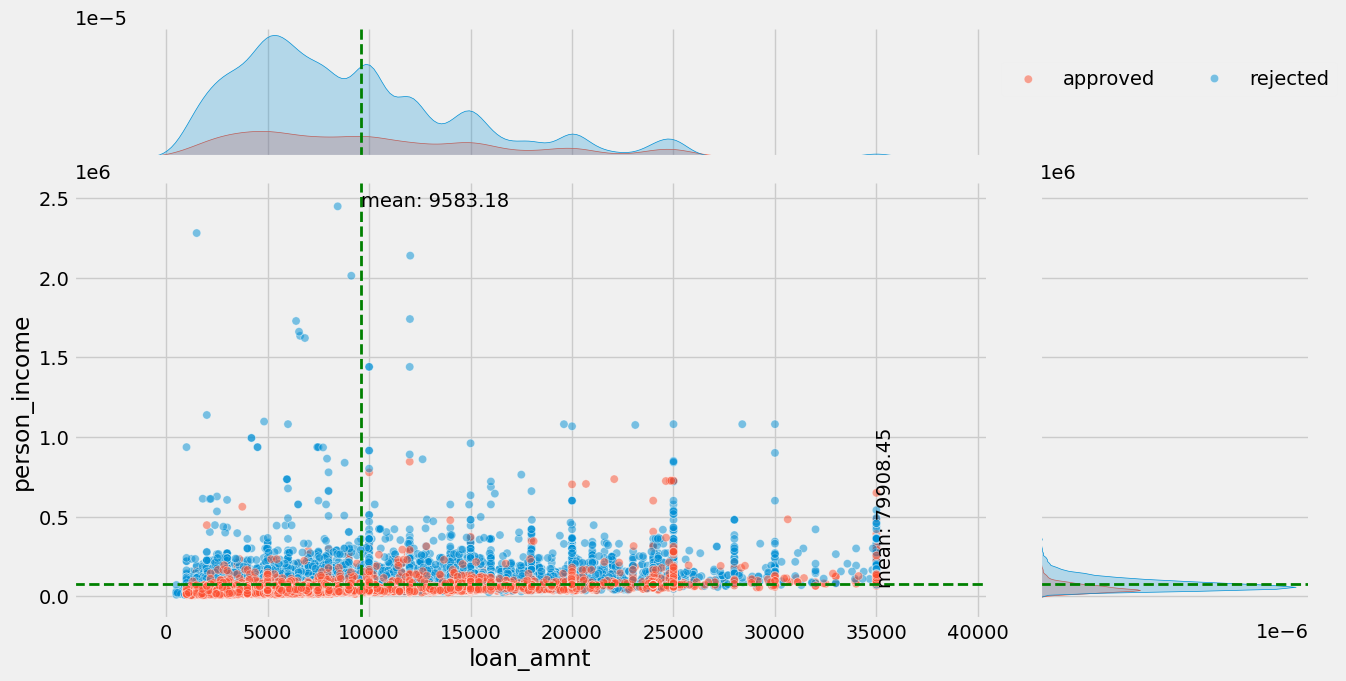

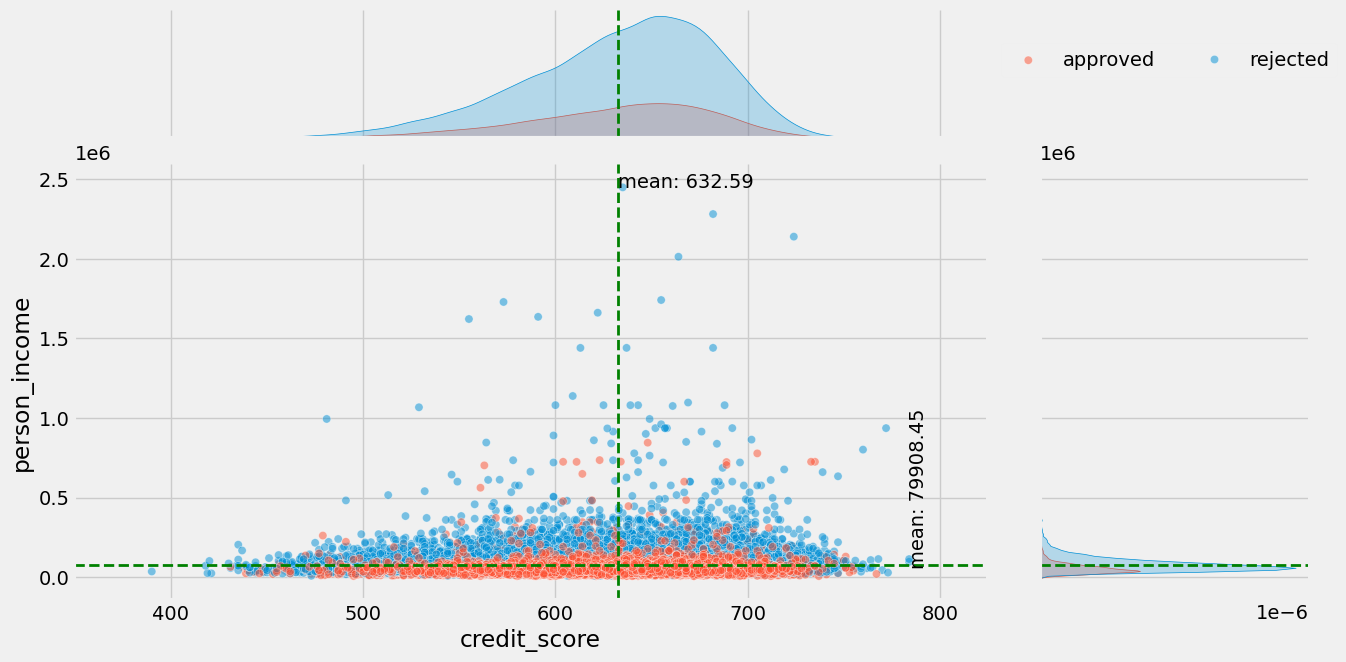

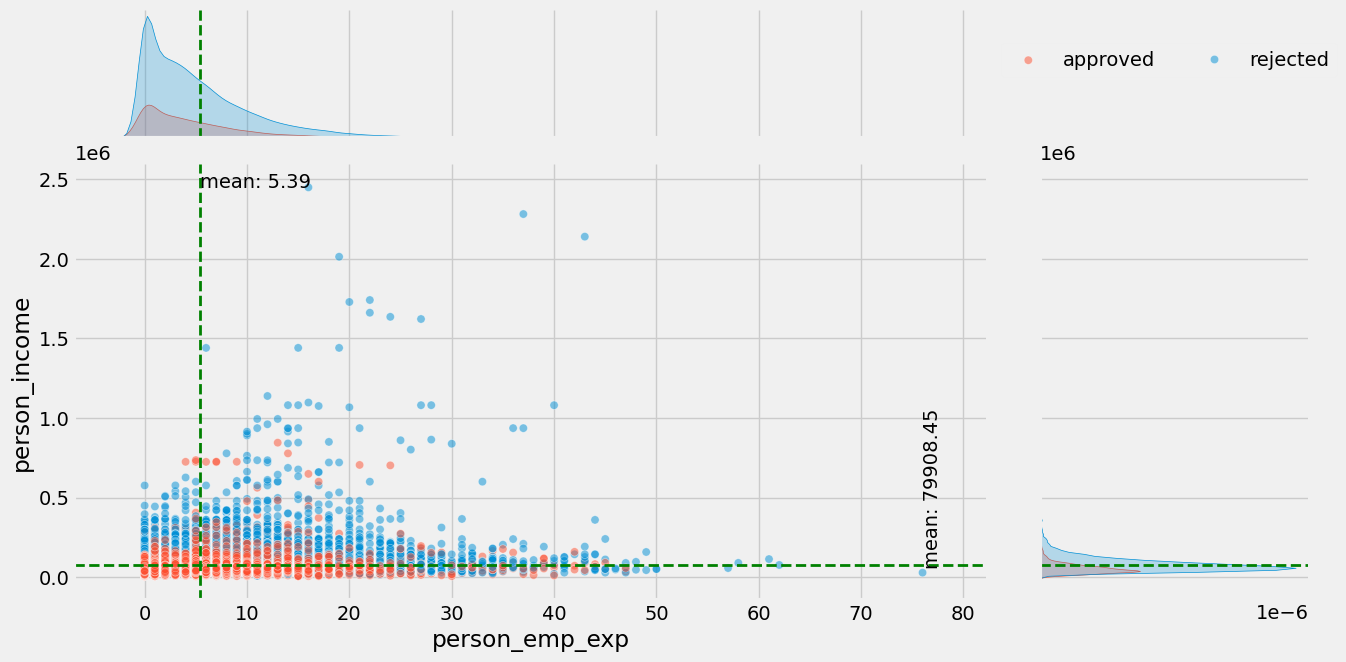

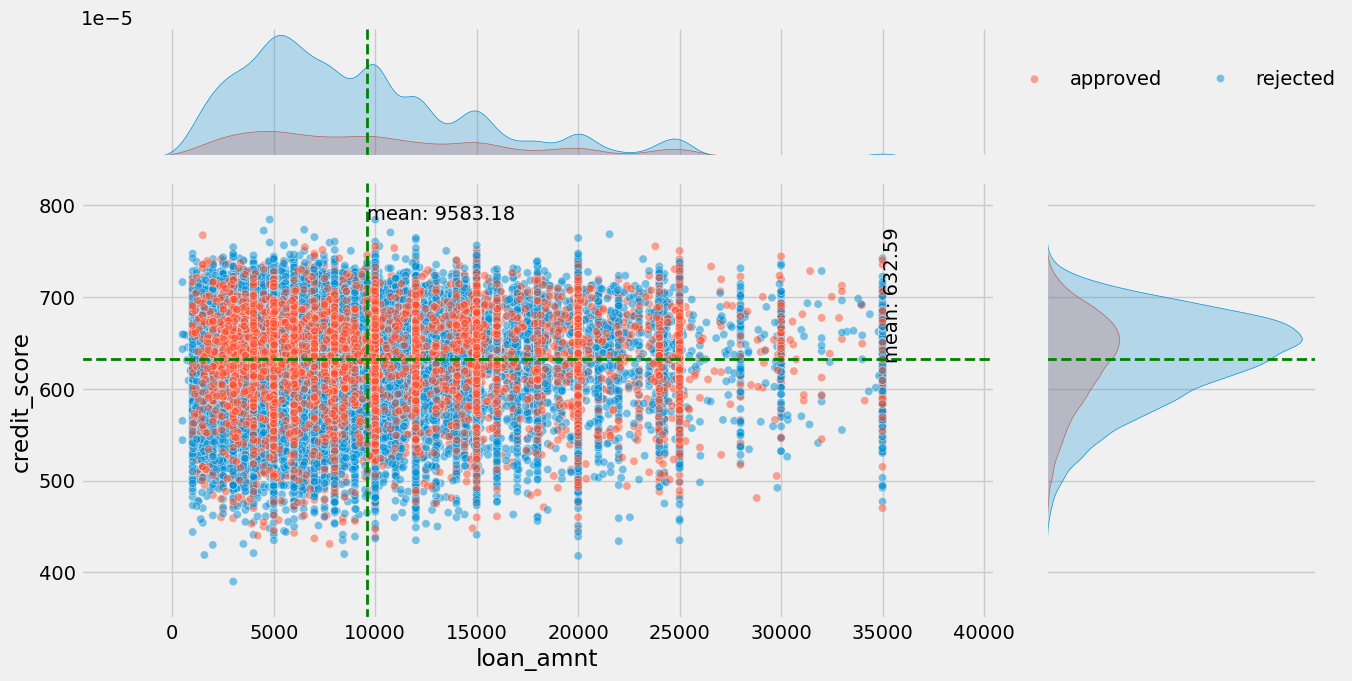

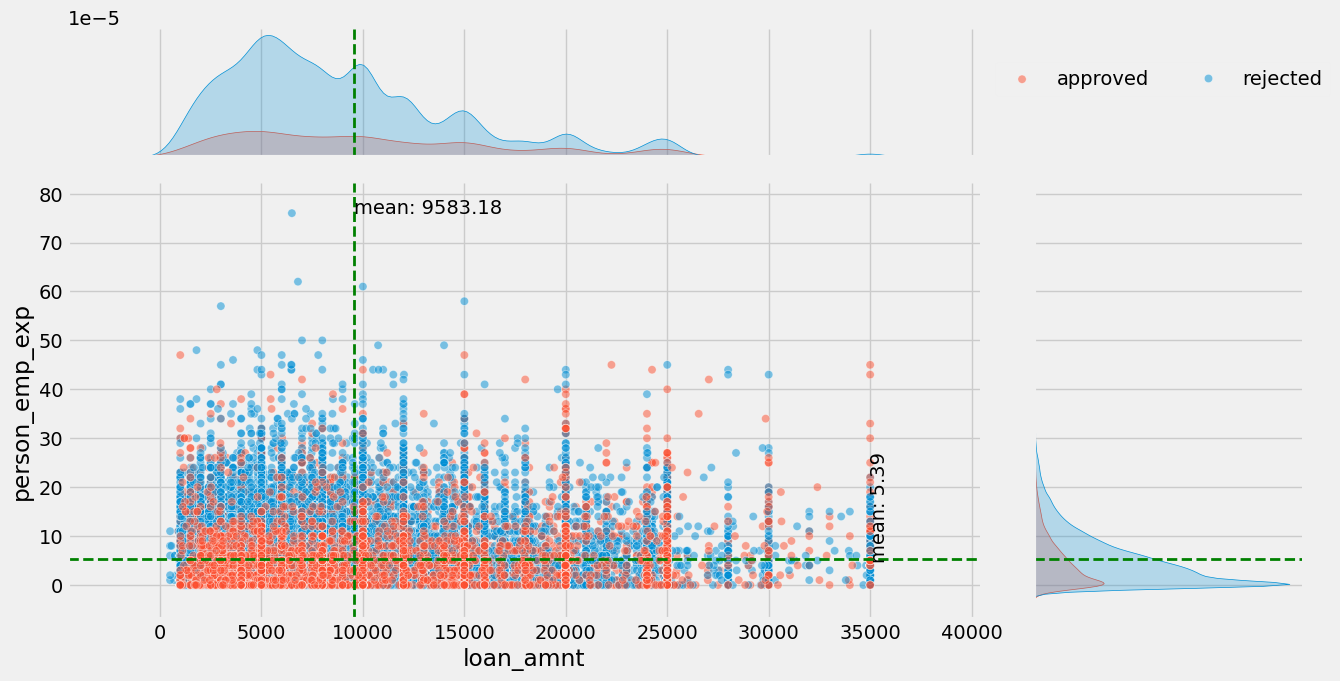

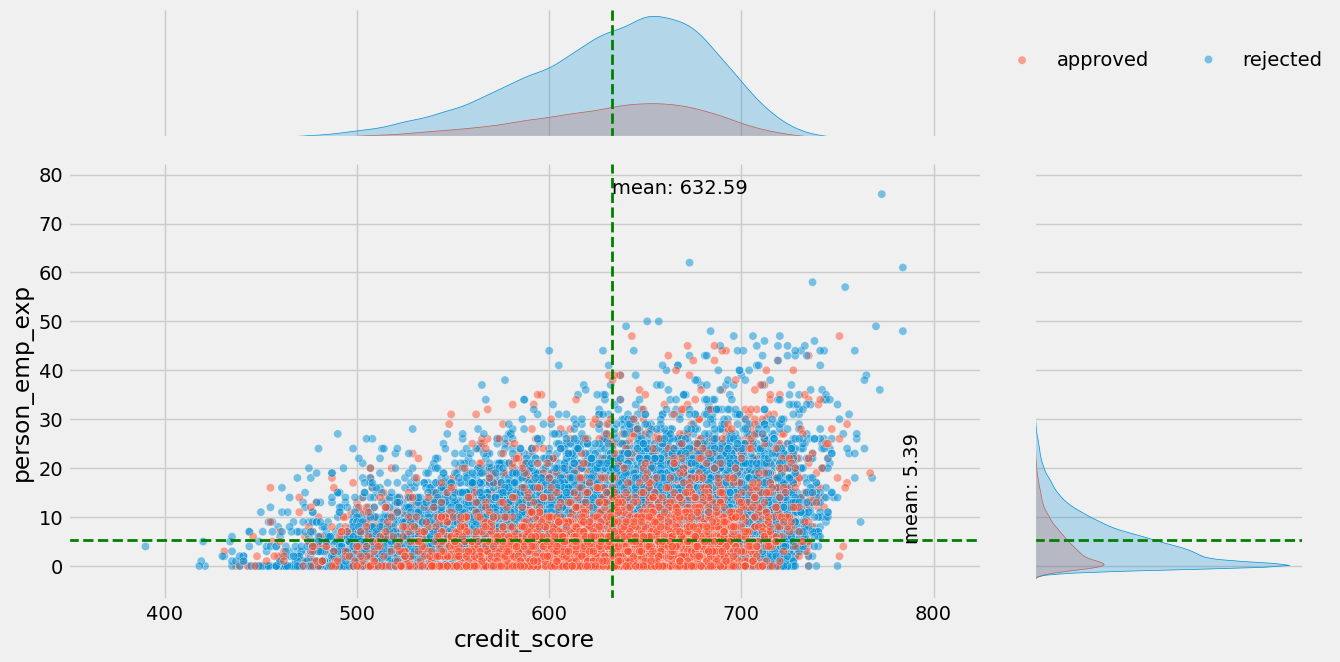

In [259]:
def joint_plot(x, y):
    
    plt.style.use("fivethirtyeight")
    plot = sns.jointplot(data = data, x = x, y = y, ratio = 3, hue = "loan_status", alpha = 0.5, marginal_ticks=False)
    plot.refline(x=data[x].mean(), y=data[y].mean(), marginal=True, lw = 2, color = "green")
    plt.gcf().set_size_inches(15, 7)
    plt.text(x = data[x].mean(), y = np.max(data[y]), s = f"mean: {data[x].mean():.2f}", fontdict={"color": "black"})
    plt.text(x = np.max(data[x]), y = data[y].mean(), s = f"mean: {data[y].mean():.2f}", fontdict={"color": "black", "rotation": 90})
    plt.legend(loc = "upper center", bbox_to_anchor = (1.20, 1.30), ncols = 2, labels = ["approved", "rejected"],  framealpha = 0.01)
    plt.grid("off")

joint_plot("loan_amnt", "person_income")
joint_plot("credit_score", "person_income")
joint_plot("person_emp_exp", "person_income")
joint_plot("loan_amnt", "credit_score")
joint_plot("loan_amnt", "person_emp_exp")
joint_plot("credit_score", "person_emp_exp")

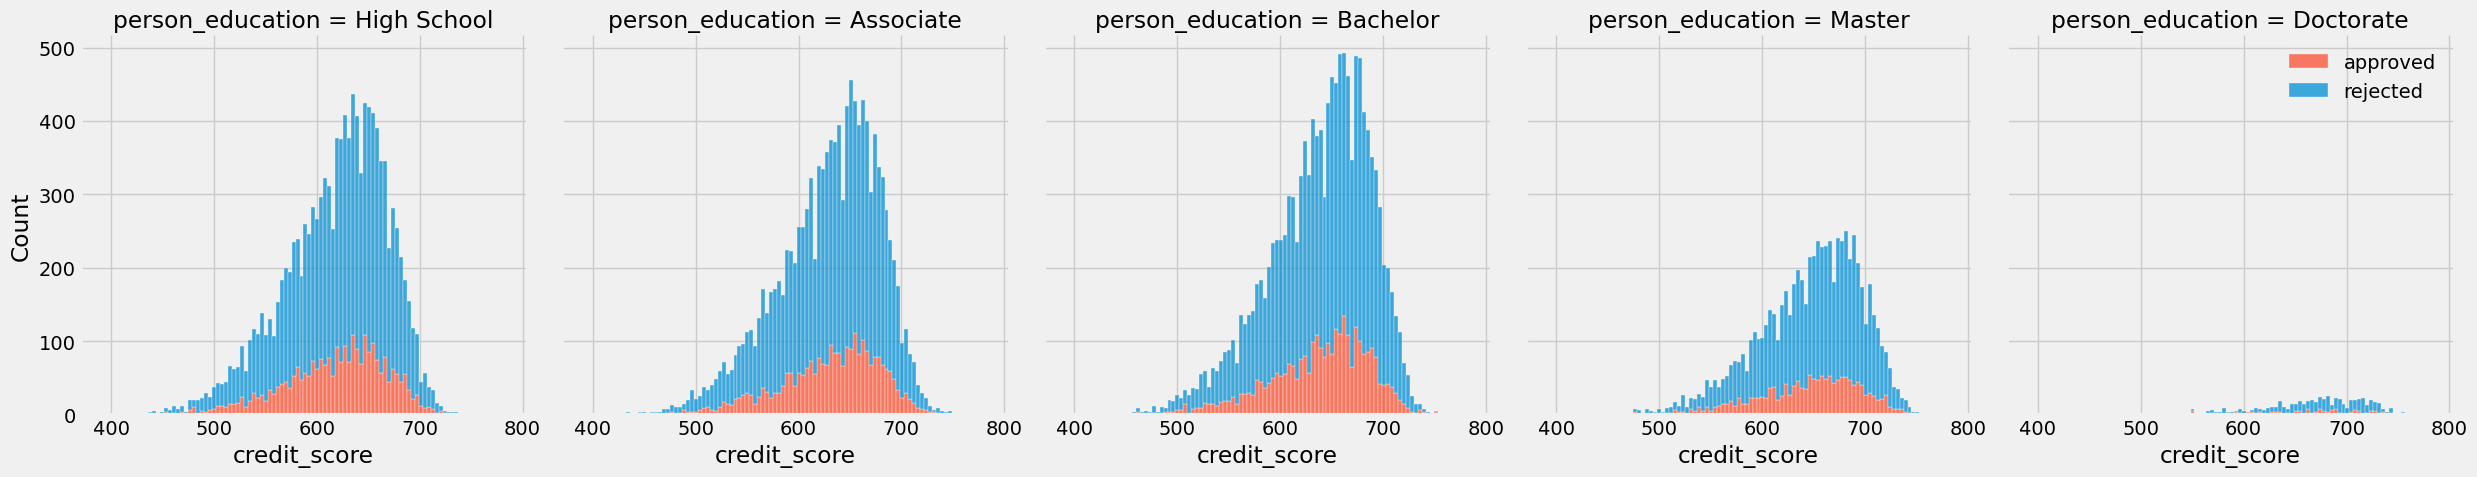

In [260]:
sns.displot(data = data, 
            x = "credit_score", 
            col = "person_education",  
            hue = "loan_status", 
            multiple = "stack", 
            col_order=['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate'], 
            legend=False)

plt.legend(labels = ["approved", "rejected"], framealpha = 0.01);

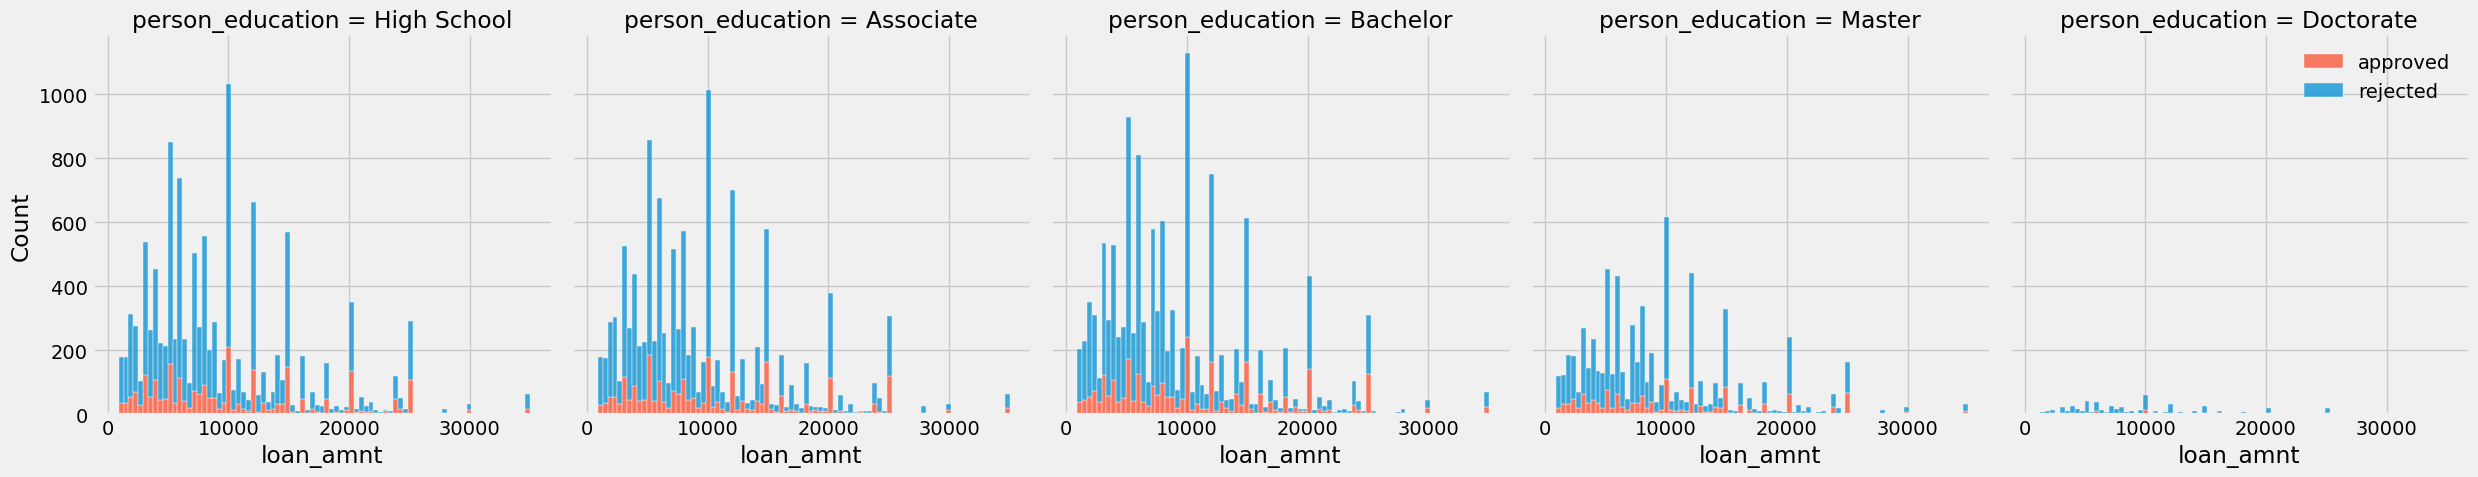

In [262]:
sns.displot(data = data, 
            x = "loan_amnt", 
            col = "person_education", 
            hue = "loan_status",
            multiple = "stack", 
            col_order=['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate'], 
            legend=False)
plt.legend(labels = ["approved", "rejected"], framealpha = 0.01);

# MODELS

In [266]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, auc, classification_report, confusion_matrix

In [268]:
model_pipe = Pipeline([
    ("transformer", cols_transformed),
    ("model", LinearRegression())
])

## Logistic Regression

In [99]:
params = [
    {
        "model": [LogisticRegression(solver="saga")],
        "model__penalty": ['l1', 'l2', 'elasticnet'],
        "model__max_iter": [200, 500, 750, 1000],
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
    }
]

grid = GridSearchCV(
    estimator=model_pipe,
    param_grid=params,
    n_jobs= -1,
    cv = 10,
    scoring = "accuracy",
    verbose=2
)

grid.fit(x_train, y_train)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('encoder_label',
                                                                         Pipeline(steps=[('label '
                                                                                          'encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['person_gender',
                                                                          'previous_loan_defaults_on_file']),
                                                                        ('encoder_ohe',
                                                                         Pipeline(steps=[('one-hot '
                                                                                          'encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['person_...
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length',
                                                                          'credit_score'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(solver='saga')],
                          'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                          'model__max_iter': [200, 500, 750, 1000],
                          'model__penalty': ['l1', 'l2', 'elasticnet']}],
             scoring='accuracy', verbose=2)

### Best HyperParameters

In [165]:
best_params = pd.DataFrame(grid.best_params_, index = [0]).set_index("model");best_params

model__C  model__l1_ratio  model__max_iter  \
model                                                                           
LogisticRegression(solver='saga')         1             0.75              200   

                                  model__penalty  
model                                             
LogisticRegression(solver='saga')             l2

### Val and Test Scores

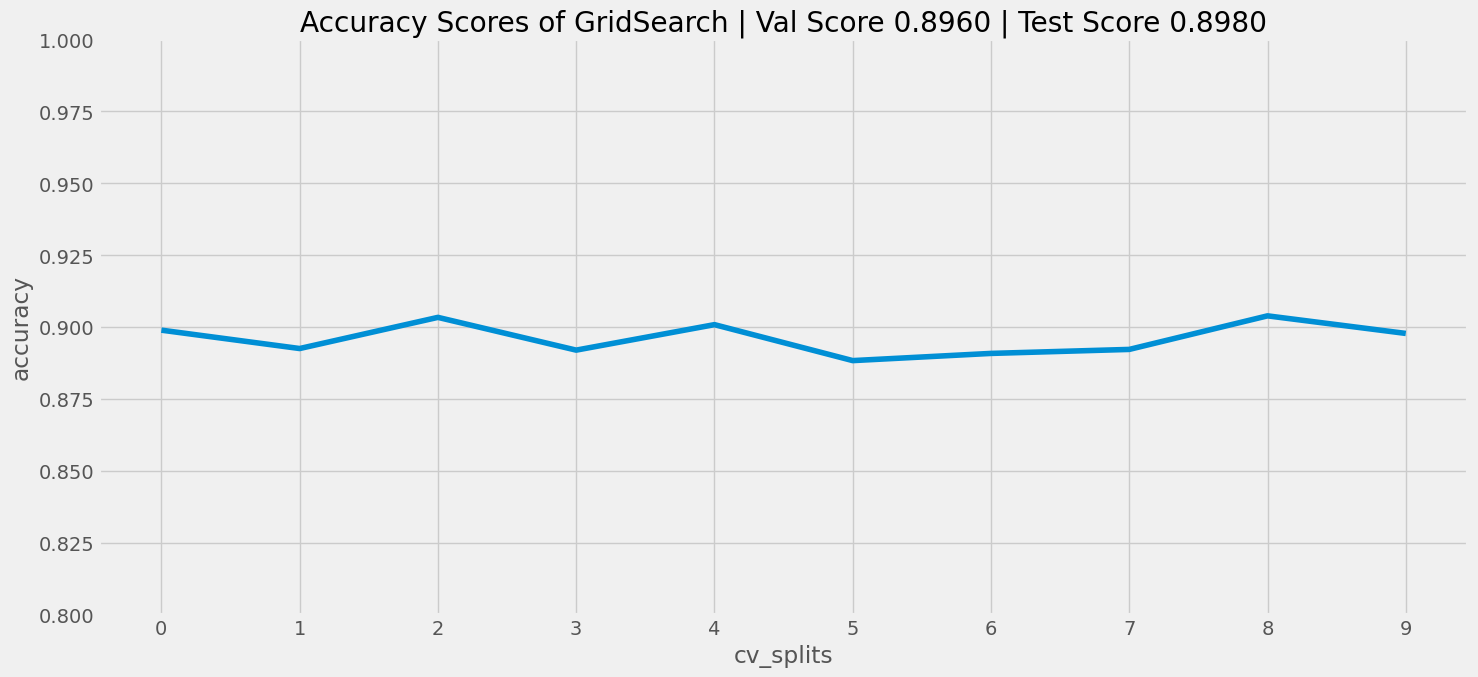

In [224]:
pd.DataFrame(grid.cv_results_).sort_values(by = "rank_test_score").iloc[0, -13:-3].plot()
plt.xticks(range(10), labels=range(10))
plt.xlabel("cv_splits")
plt.ylabel("accuracy")
plt.ylim(0.8, 1)
plt.gcf().set_size_inches(15, 7)
plt.title(f"Accuracy Scores of GridSearch | Val Score {grid.best_score_:.4f} | Test Score {grid.score(x_test, y_test):.4f}")
plt.tight_layout()

### ROC Curve

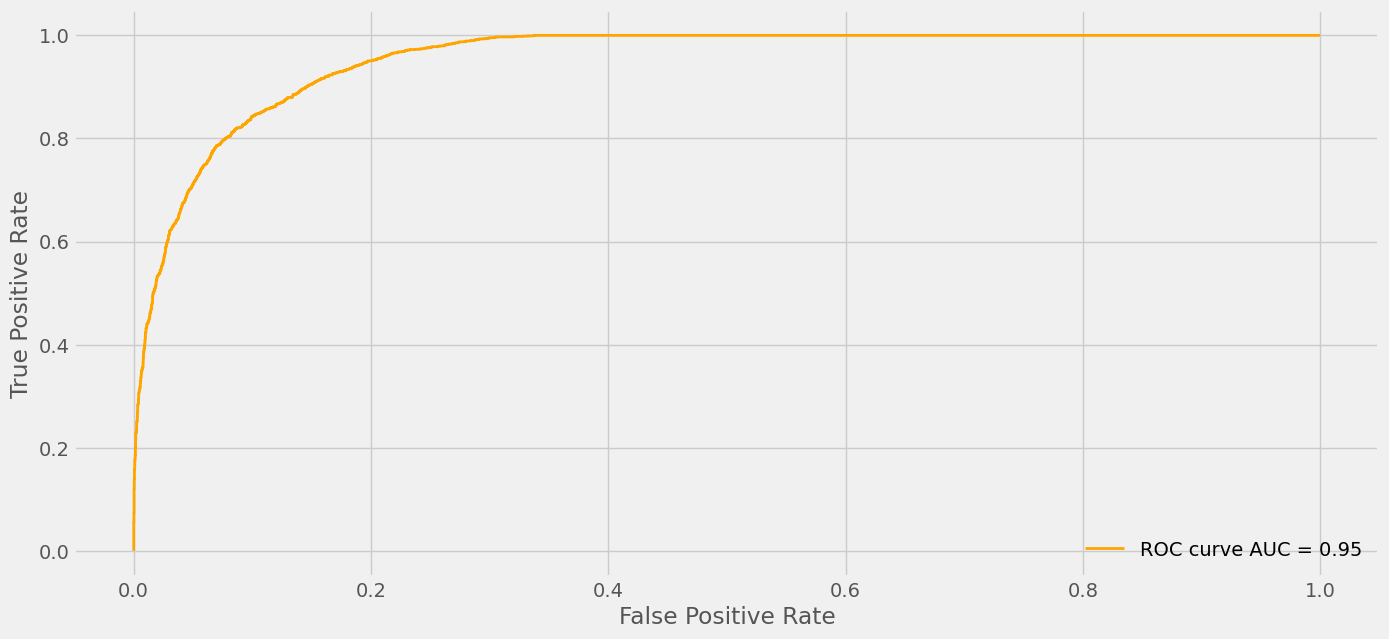

In [229]:
y_pred = grid.predict(x_test)
y_score = grid.predict_proba(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve AUC = {roc_auc:.2f}')
plt.legend(loc="lower right", framealpha = 0)
plt.gcf().set_size_inches(15, 7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid("off")

### Classification Report

In [266]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).rename({"0": "rejected-0", "1":"approved-1"}, axis = 1).T

precision    recall  f1-score      support
rejected-0     0.934419  0.934419  0.934419  6999.000000
approved-1     0.770500  0.770500  0.770500  2000.000000
accuracy       0.897989  0.897989  0.897989     0.897989
macro avg      0.852460  0.852460  0.852460  8999.000000
weighted avg   0.897989  0.897989  0.897989  8999.000000

### Confusion Matrix

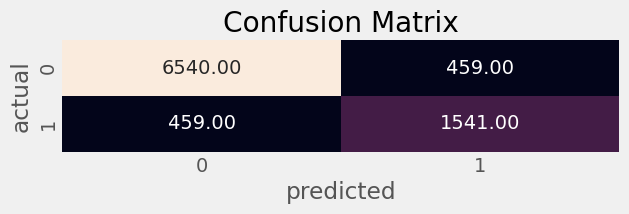

In [252]:
g = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".2f", cbar=False)
g.set_ylabel("actual")
g.set_xlabel("predicted")
g.set_title("Confusion Matrix")
g.set_aspect(0.2)


## K-Nearest Neighbors (KNN)

In [259]:
params = [
    {
        "model": [KNeighborsClassifier()],
        "model__n_neighbors":[3, 5, 7, 10, 15, 20],
        "model__weights": ['uniform', 'distance'],
        "model__algorithm": ['brute', 'ball_tree', 'kd_tree'],
        "model__leaf_size": [10, 30, 50, 70],
        "model__p":[1, 2]
    }

]

grid_knn = GridSearchCV(
    estimator=model_pipe,
    param_grid=params,
    n_jobs= -1,
    cv = 10,
    scoring= "accuracy",
    verbose=2
)

grid_knn.fit(x_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('encoder_label',
                                                                         Pipeline(steps=[('label '
                                                                                          'encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['person_gender',
                                                                          'previous_loan_defaults_on_file']),
                                                                        ('encoder_ohe',
                                                                         Pipeline(steps=[('one-hot '
                                                                                          'encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['person_...
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length',
                                                                          'credit_score'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [KNeighborsClassifier()],
                          'model__algorithm': ['brute', 'ball_tree', 'kd_tree'],
                          'model__leaf_size': [10, 30, 50, 70],
                          'model__n_neighbors': [3, 5, 7, 10, 15, 20],
                          'model__p': [1, 2],
                          'model__weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=2)

### Best HyperParameters

In [268]:
best_params = pd.DataFrame(grid_knn.best_params_, index = [0]).set_index("model");best_params

model__algorithm  model__leaf_size  model__n_neighbors  \
model                                                                           
KNeighborsClassifier()            brute                10                  20   

                        model__p model__weights  
model                                            
KNeighborsClassifier()         1       distance

### Val and Test Scores

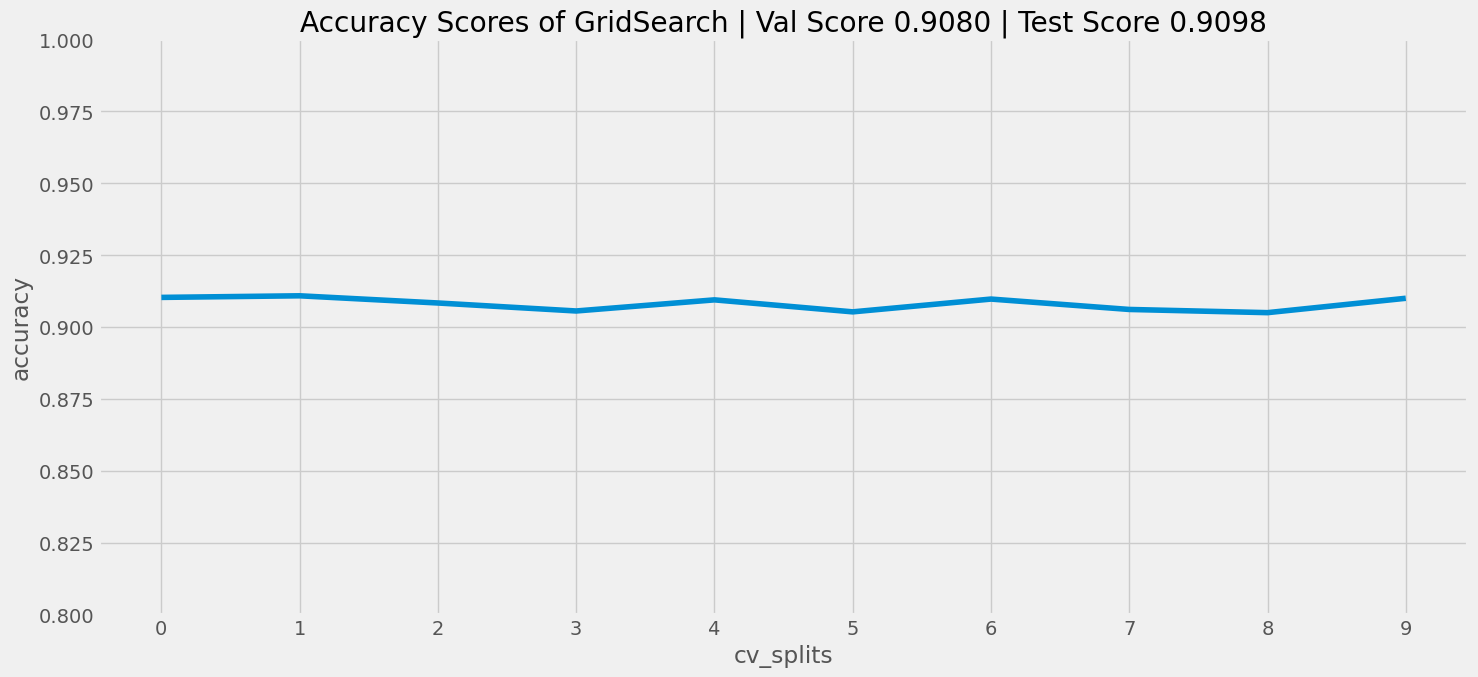

In [263]:
pd.DataFrame(grid_knn.cv_results_).sort_values(by = "rank_test_score").iloc[0, -13:-3].plot()
plt.xticks(range(10), labels=range(10))
plt.xlabel("cv_splits")
plt.ylabel("accuracy")
plt.ylim(0.8, 1)
plt.gcf().set_size_inches(15, 7)
plt.title(f"Accuracy Scores of GridSearch | Val Score {grid_knn.best_score_:.4f} | Test Score {grid_knn.score(x_test, y_test):.4f}")
plt.tight_layout()

### Classification Report

In [265]:
y_pred_knn = grid_knn.predict(x_test)
pd.DataFrame(classification_report(y_test, y_pred_knn, output_dict=True)).rename({"0": "rejected-0", "1":"approved-1"}, axis = 1).T

precision    recall  f1-score      support
rejected-0     0.920141  0.967995  0.943462  6999.000000
approved-1     0.863081  0.706000  0.776678  2000.000000
accuracy       0.909768  0.909768  0.909768     0.909768
macro avg      0.891611  0.836998  0.860070  8999.000000
weighted avg   0.907460  0.909768  0.906395  8999.000000

### Confusion Matrix

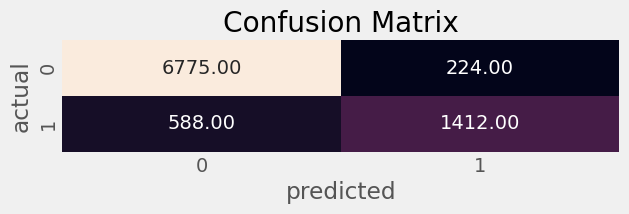

In [267]:
g = sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt=".2f", cbar=False)
g.set_ylabel("actual")
g.set_xlabel("predicted")
g.set_title("Confusion Matrix")
g.set_aspect(0.2)

## Support Vector Machines (SVM)

In [83]:
params = [
    {
        "model": [SVC()],
        "model__C": [10],
        "model__kernel": ["rbf"],
        "model__gamma": [1,0.1,0.01,0.001]  
    }
]

grid_svc = GridSearchCV(
    estimator=model_pipe,
    param_grid=params,
    cv=10,
    n_jobs= -1,
    scoring="accuracy",
    verbose = 2
)
grid_svc.fit(x_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('encoder_label',
                                                                         Pipeline(steps=[('label '
                                                                                          'encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['person_gender',
                                                                          'previous_loan_defaults_on_file']),
                                                                        ('encoder_ohe',
                                                                         Pipeline(steps=[('one-hot '
                                                                                          'encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['person_...
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['person_age',
                                                                          'person_income',
                                                                          'person_emp_exp',
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length',
                                                                          'credit_score'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [SVC()], 'model__C': [10],
                          'model__gamma': [1, 0.1, 0.01, 0.001],
                          'model__kernel': ['rbf']}],
             scoring='accuracy', verbose=2)

### Best HyperParameters

In [85]:
best_params = pd.DataFrame(grid_svc.best_params_, index = [0]).set_index("model");best_params

model__C  model__gamma model__kernel
model                                      
SVC()        10           0.1           rbf

### Val And Test Scores

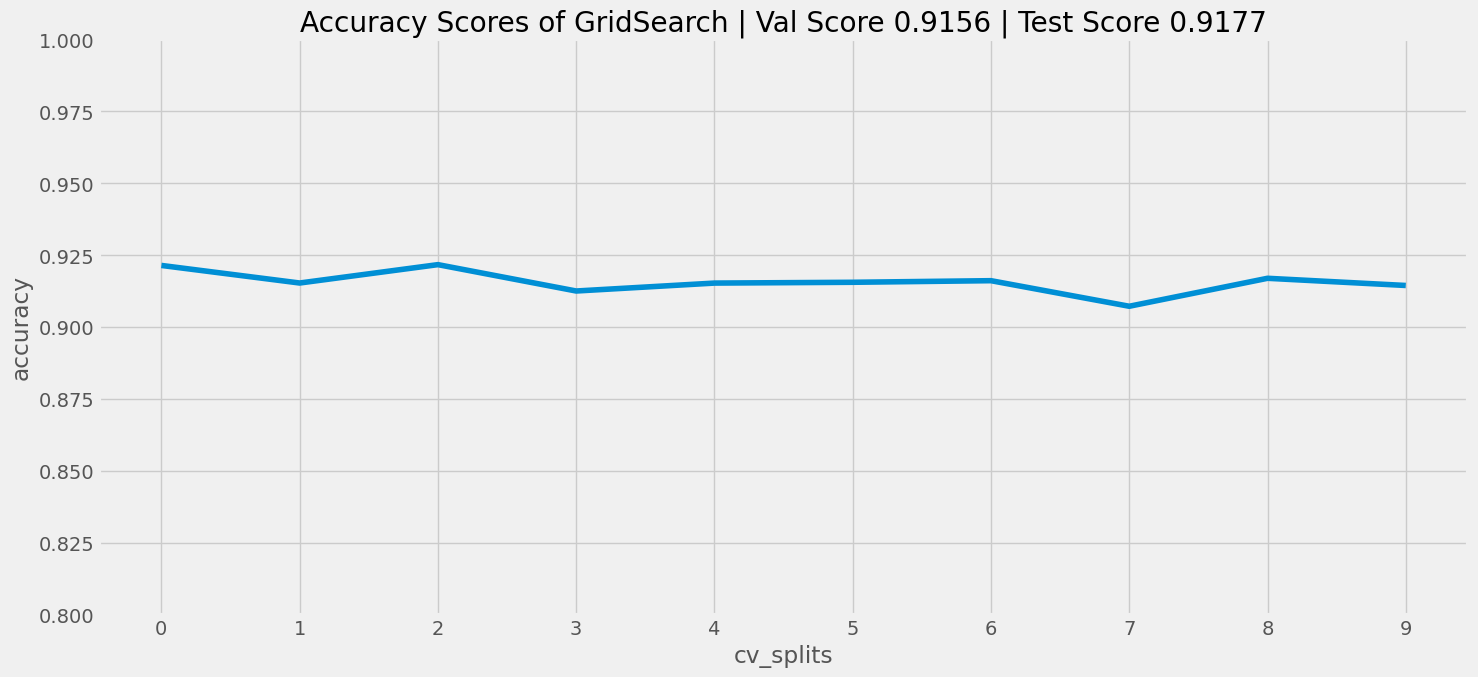

In [87]:
pd.DataFrame(grid_svc.cv_results_).sort_values(by = "rank_test_score").iloc[0, -13:-3].plot()
plt.xticks(range(10), labels=range(10))
plt.xlabel("cv_splits")
plt.ylabel("accuracy")
plt.ylim(0.8, 1)
plt.gcf().set_size_inches(15, 7)
plt.title(f"Accuracy Scores of GridSearch | Val Score {grid_svc.best_score_:.4f} | Test Score {grid_svc.score(x_test, y_test):.4f}")
plt.tight_layout()

### Classification Report

In [93]:
y_pred_scv = grid_svc.predict(x_test)
pd.DataFrame(classification_report(y_test, y_pred_scv, output_dict=True)).rename({"0": "rejected-0", "1":"approved-1"}, axis = 1).T

precision    recall  f1-score      support
rejected-0     0.935794  0.959994  0.947740  6999.000000
approved-1     0.846069  0.769500  0.805970  2000.000000
accuracy       0.917658  0.917658  0.917658     0.917658
macro avg      0.890932  0.864747  0.876855  8999.000000
weighted avg   0.915853  0.917658  0.916232  8999.000000

### Confusion Matrix

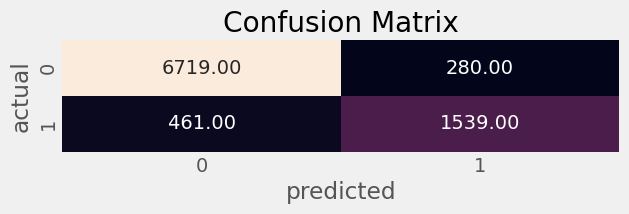

In [95]:
g = sns.heatmap(confusion_matrix(y_test, y_pred_scv), annot=True, fmt=".2f", cbar=False)
g.set_ylabel("actual")
g.set_xlabel("predicted")
g.set_title("Confusion Matrix")
g.set_aspect(0.2)

## Random Forest

In [106]:
params = [
    {
        "model": [RandomForestClassifier()],
        "model__n_estimators": [200, 400, 600, 1000],
        "model__max_depth": [10, 20, 30],
        "model__max_features": [3, 5, 8, 10],
        
    }
]

grid_rf = GridSearchCV(
    estimator=model_pipe,
    param_grid=params,
    scoring="accuracy",
    n_jobs= -1,
    verbose = 3,
    
)

grid_rf.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('encoder_label',
                                                                         Pipeline(steps=[('label '
                                                                                          'encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['person_gender',
                                                                          'previous_loan_defaults_on_file']),
                                                                        ('encoder_ohe',
                                                                         Pipeline(steps=[('one-hot '
                                                                                          'encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['person_home_o...
                                                                          'person_income',
                                                                          'person_emp_exp',
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length',
                                                                          'credit_score'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestClassifier()],
                          'model__max_depth': [10, 20, 30],
                          'model__max_features': [3, 5, 8, 10],
                          'model__n_estimators': [200, 400, 600, 100]}],
             scoring='accuracy', verbose=3)

### Best HyperParameters

In [184]:
best_params = pd.DataFrame(best_p.items()).set_index(0);best_params.T.set_index("model")

0                        model__max_depth model__max_features  \
model                                                           
RandomForestClassifier()               30                   5   

0                        model__n_estimators  
model                                         
RandomForestClassifier()                 600

### Val and Test Scores

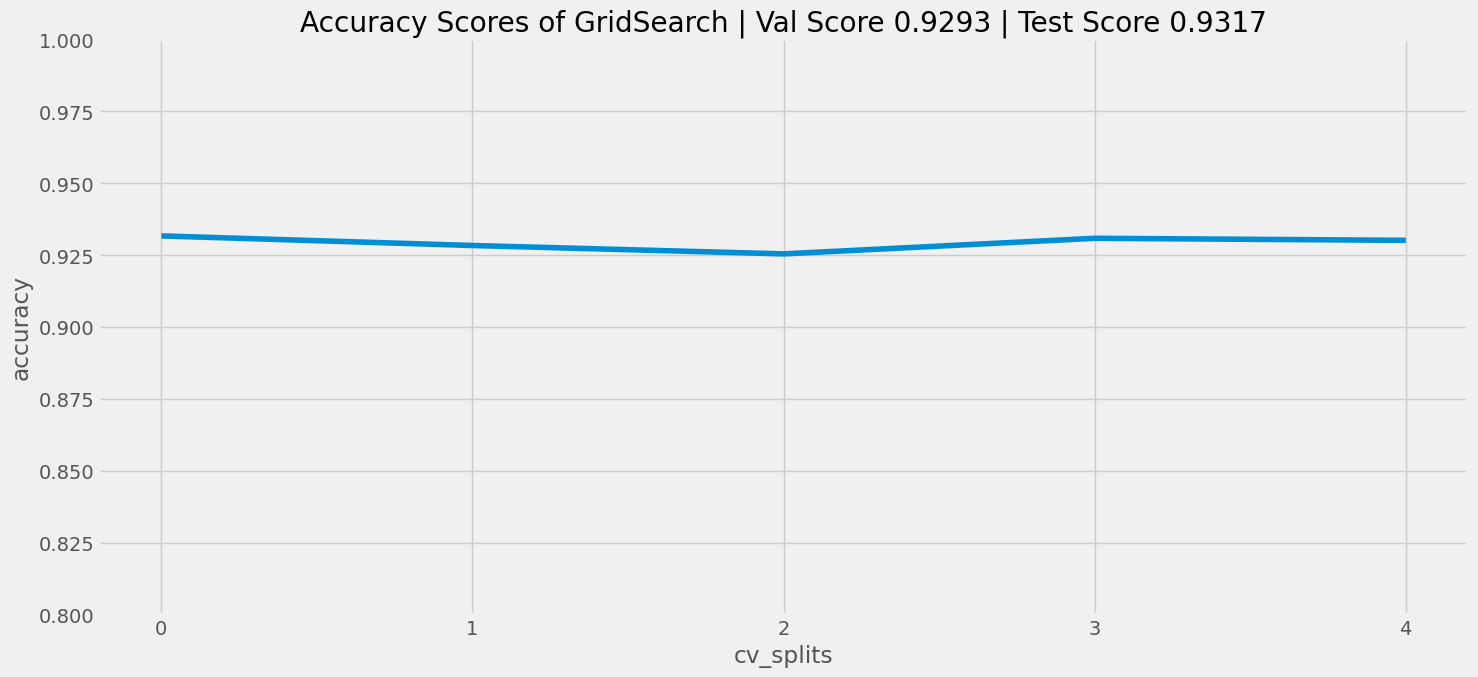

In [204]:
pd.DataFrame(grid_rf.cv_results_).sort_values(by = "rank_test_score").iloc[0, -8:-3].plot()
plt.xticks(range(5), labels=range(5))
plt.xlabel("cv_splits")
plt.ylabel("accuracy")
plt.ylim(0.8, 1)
plt.gcf().set_size_inches(15, 7)
plt.title(f"Accuracy Scores of GridSearch | Val Score {grid_rf.best_score_:.4f} | Test Score {grid_rf.score(x_test, y_test):.4f}")
plt.tight_layout()

### Classification Report

In [207]:
y_pred_rf = grid_rf.predict(x_test)
pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).rename({"0": "rejected-0", "1":"approved-1"}, axis = 1).T

precision    recall  f1-score      support
rejected-0     0.943210  0.970567  0.956693  6999.000000
approved-1     0.885364  0.795500  0.838030  2000.000000
accuracy       0.931659  0.931659  0.931659     0.931659
macro avg      0.914287  0.883034  0.897362  8999.000000
weighted avg   0.930354  0.931659  0.930321  8999.000000

### Confusion Matrix

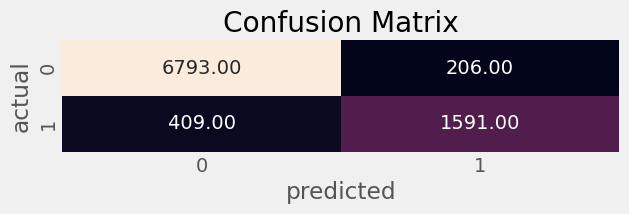

In [213]:
g = sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt=".2f", cbar=False)
g.set_ylabel("actual")
g.set_xlabel("predicted")
g.set_title("Confusion Matrix")
g.set_aspect(0.2)

## LightGBM

In [223]:
params = [
    {
      "model": [LGBMClassifier()],
      "model__num_leaves": [50, 100, 150, 200],
      "model__max_depth" : [10, 20, 30],
      "model__n_estimators" : [200, 400, 600, 800],
      "model__subsample": [0.6, 0.8, 0.90]  
    }
]


grid_lgmb = GridSearchCV(
    estimator=model_pipe,
    param_grid=params,
    scoring = "accuracy",
    n_jobs = -1,
    verbose = 3,
)

grid_lgmb.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Number of positive: 8000, number of negative: 27994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 35994, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222259 -> initscore=-1.252549
[LightGBM] [Info] Start training from score -1.252549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('encoder_label',
                                                                         Pipeline(steps=[('label '
                                                                                          'encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['person_gender',
                                                                          'previous_loan_defaults_on_file']),
                                                                        ('encoder_ohe',
                                                                         Pipeline(steps=[('one-hot '
                                                                                          'encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['person_home_o...
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length',
                                                                          'credit_score'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LGBMClassifier()],
                          'model__max_depth': [10, 20, 30],
                          'model__n_estimators': [200, 400, 600, 800],
                          'model__num_leaves': [50, 100, 150, 200],
                          'model__subsample': [0.6, 0.8, 0.9]}],
             scoring='accuracy', verbose=3)

### Best HyperParameters

In [231]:
best_params = pd.DataFrame(grid_lgmb.best_params_, index = [0]).set_index("model");best_params

model__max_depth  model__n_estimators  model__num_leaves  \
model                                                                        
LGBMClassifier()                10                  200                 50   

                  model__subsample  
model                               
LGBMClassifier()               0.6

### Val and Test Scores

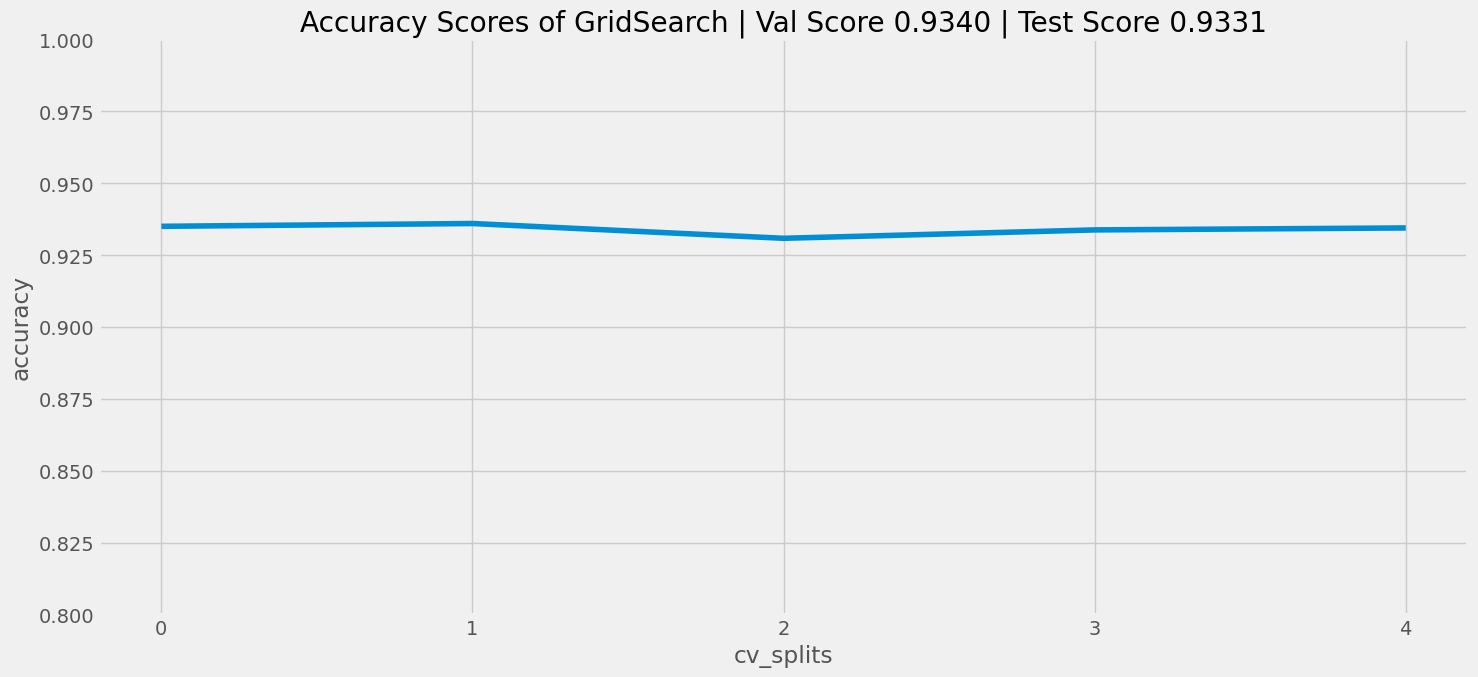

In [236]:
pd.DataFrame(grid_lgmb.cv_results_).sort_values(by = "rank_test_score").iloc[0, -8:-3].plot()
plt.xticks(range(5), labels=range(5))
plt.xlabel("cv_splits")
plt.ylabel("accuracy")
plt.ylim(0.8, 1)
plt.gcf().set_size_inches(15, 7)
plt.title(f"Accuracy Scores of GridSearch | Val Score {grid_lgmb.best_score_:.4f} | Test Score {grid_lgmb.score(x_test, y_test):.4f}")
plt.tight_layout()

### Classification Report

In [247]:
y_pred_lgbm = grid_lgmb.predict(x_test)
pd.DataFrame(classification_report(y_test, y_pred_lgbm, output_dict=True)).rename({"0": "rejected-0", "1":"approved-1"}, axis = 1).T

precision    recall  f1-score      support
rejected-0     0.946780  0.968424  0.957480  6999.000000
approved-1     0.879891  0.809500  0.843229  2000.000000
accuracy       0.933104  0.933104  0.933104     0.933104
macro avg      0.913336  0.888962  0.900355  8999.000000
weighted avg   0.931914  0.933104  0.932088  8999.000000

### Confusion Matrix

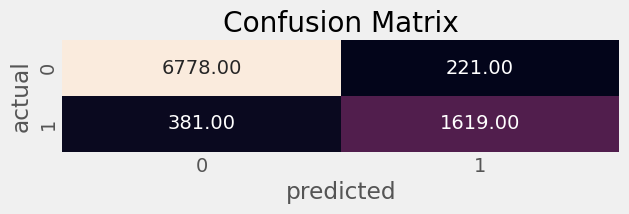

In [249]:
g = sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt=".2f", cbar=False)
g.set_ylabel("actual")
g.set_xlabel("predicted")
g.set_title("Confusion Matrix")
g.set_aspect(0.2)

## Multi-Layer Neural Network

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [101]:
with tf.device("/CPU:0"):

    model = keras.Sequential()
    model.add(keras.Input(shape = (x_train_final.shape[1],)))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    early_ = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.compile(
        optimizer="adam",
        loss = ["binary_crossentropy"],
        metrics = ["accuracy"]
    )
    
    history = model.fit(x_train_final, y_train, epochs=100, validation_split=0.10, callbacks=[early_])

Epoch 1/100
1013/1013 [==============================] - 2s 1ms/step - loss: 0.2203 - accuracy: 0.9018 - val_loss: 0.1871 - val_accuracy: 0.9128
Epoch 2/100
1013/1013 [==============================] - 1s 1ms/step - loss: 0.1888 - accuracy: 0.9145 - val_loss: 0.1788 - val_accuracy: 0.9203
Epoch 3/100
1013/1013 [==============================] - 1s 1ms/step - loss: 0.1819 - accuracy: 0.9186 - val_loss: 0.1767 - val_accuracy: 0.9206
Epoch 4/100
1013/1013 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.9207 - val_loss: 0.1759 - val_accuracy: 0.9194
Epoch 5/100
1013/1013 [==============================] - 1s 1ms/step - loss: 0.1743 - accuracy: 0.9237 - val_loss: 0.1797 - val_accuracy: 0.9172
Epoch 6/100
1013/1013 [==============================] - 1s 1ms/step - loss: 0.1720 - accuracy: 0.9221 - val_loss: 0.1777 - val_accuracy: 0.9186
Epoch 7/100
1013/1013 [==============================] - 1s 1ms/step - loss: 0.1697 - accuracy: 0.9240 - val_loss: 0.1785 - val_ac

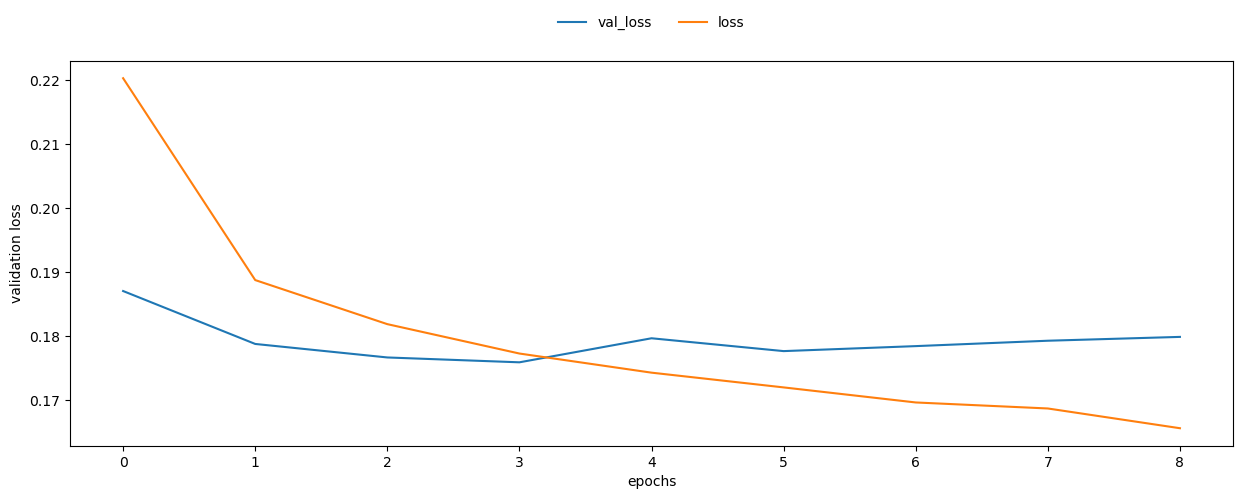

In [103]:
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["loss"], label = "loss")
plt.xticks(history.epoch);
plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.legend(loc = "upper center", bbox_to_anchor = (0.50, 1.15), ncols = 2, framealpha = 0)
plt.gcf().set_size_inches(15,5)

### Val and Test Scores

282/282 [==============================] - 2s 5ms/step - loss: 0.1841 - accuracy: 0.9187


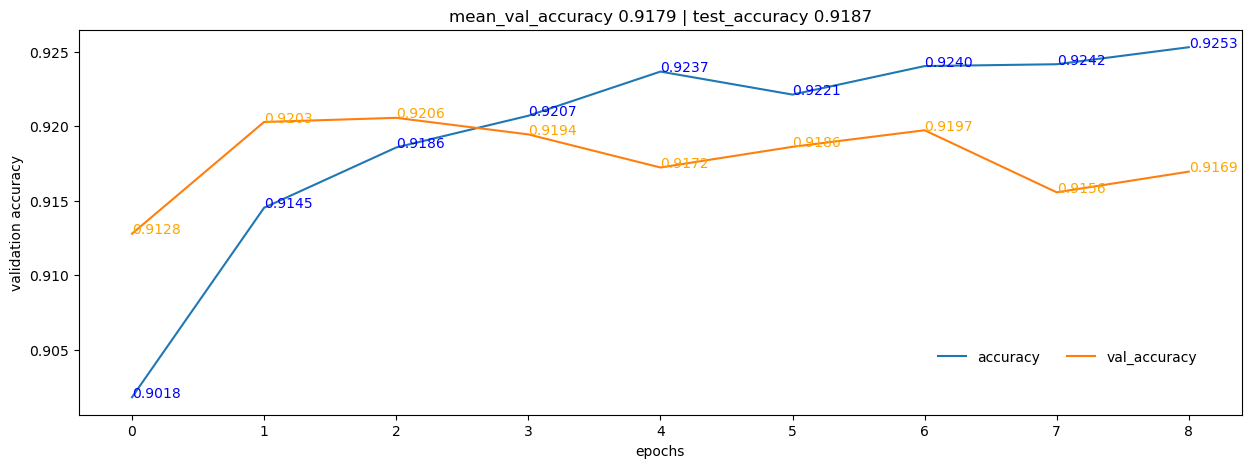

In [162]:
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xticks(history.epoch);
plt.xlabel("epochs")
plt.ylabel("validation accuracy")
plt.legend(loc = "upper center", bbox_to_anchor = (0.85, 0.20), ncols = 2, framealpha = 0)
plt.gcf().set_size_inches(15,5)
plt.title(f"mean_val_accuracy {np.mean(history.history['val_accuracy']):.4f} | test_accuracy {model.evaluate(x_test_final, y_test)[1]:.4f}")
val_acc = pd.Series(history.history["val_accuracy"], index = history.epoch)
acc = pd.Series(history.history["accuracy"], index = history.epoch)

for index, value in val_acc.items():
    plt.text(x = index, y = value, s = f"{value:.4f}", fontdict = dict(color = "orange"))


for index, value in acc.items():
    plt.text(x = index, y = value, s = f"{value:.4f}", fontdict = dict(color = "blue"))
    
    

### Classification Report

In [157]:
y_pred_nn = model.predict(x_test_final)
y_pred_label = np.where(y_pred_nn > 0.50, 1, 0)
pd.DataFrame(classification_report(y_test, y_pred_label, output_dict=True)).rename({"0": "rejected-0", "1":"approved-1"}, axis = 1).T

282/282 [==============================] - 1s 3ms/step


precision    recall  f1-score      support
rejected-0     0.931315  0.966710  0.948682  6999.000000
approved-1     0.865629  0.750500  0.803964  2000.000000
accuracy       0.918658  0.918658  0.918658     0.918658
macro avg      0.898472  0.858605  0.876323  8999.000000
weighted avg   0.916716  0.918658  0.916519  8999.000000

### Confusion Matrix

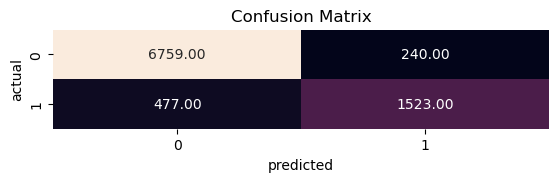

In [89]:
g = sns.heatmap(confusion_matrix(y_test, y_pred_label), annot=True, fmt=".2f", cbar=False)
g.set_ylabel("actual")
g.set_xlabel("predicted")
g.set_title("Confusion Matrix")
g.set_aspect(0.2)